In [134]:
# ===========================================
# IMPORTS, DATA LOADING AND DATE 
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import itertools
import statsmodels.api as sm
from datetime import datetime, time
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import grangercausalitytests, coint
from scipy.stats import zscore, spearmanr
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, 
    accuracy_score, mean_squared_error, mean_absolute_error, 
    median_absolute_error, r2_score, make_scorer, f1_score
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, optimizers
from tqdm import tqdm
import joblib
import random
import ta
from collections import defaultdict, deque
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import torch
import torch.nn as nn
import torch.optim as optim
#!pip install optuna

sns.set(style='whitegrid')

# ---------------------- Utility Functions ----------------------
def get_season(date):
    month = date.month
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

def calculate_zscore(series):
    return (series - series.mean()) / series.std()

# ---------------------- Load Data ----------------------
ALL_PATH = '/Users/gaetanledu/Documents/CASE/Germany/ALL.csv'
GAS_PATH = '/Users/gaetanledu/Documents/CASE/Germany/Gas_storage_level.csv'
df = pd.read_csv(ALL_PATH)
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')

# ---------------------- Clean Numeric Columns ----------------------
numeric_cols = df.columns.drop('Start date')
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df['Hour'] = df['Start date'].dt.hour

# ---------------------- add months details ----------------------
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df['Month'] = df['Start date'].dt.strftime('%b')  # e.g., 'Jan', 'Feb'
df['Month'] = pd.Categorical(df['Month'], categories=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], ordered=True)

# ---------------------- Add Basic Features ----------------------
df['Season'] = df['Start date'].apply(get_season)
df['Residual Load (%)'] = (df['Residual load [MWh]'] / df['grid load [MWh]']) * 100
df['Forecast Error (%)'] = ((df['grid load [MWh] forecasted'] - df['grid load [MWh]']) / df['grid load [MWh]']) * 100
df['Residual Load Forecast Error (%)'] = ((df['Residual load [MWh] forecasted'] - df['Residual load [MWh]']) / df['Residual load [MWh]']) * 100

# ---------------------- Plot: Real vs Forecasted load and residual load ----------------------
df['Residual Load Forecast Error'] = df['Residual load [MWh] forecasted'] - df['Residual load [MWh]']
df['Forecast Error'] = df['grid load [MWh] forecasted'] - df['grid load [MWh]']

column_names = list(df.columns.values)
print(column_names)

dfgas = pd.read_csv(GAS_PATH)
dfgas['Date'] = pd.to_datetime(dfgas['Date'], format='%m/%d/%y')
# ---------------------- Handle Missing Data ----------------------
# Forward fill first two NaN values in TTF columns
dfgas['TTF Spot Price'] = dfgas['TTF Spot Price'].fillna(method='ffill', limit=2)
dfgas['TTF Open'] = dfgas['TTF Open'].fillna(method='ffill', limit=2)
dfgas['TTF High'] = dfgas['TTF High'].fillna(method='ffill', limit=2)
dfgas['TTF Low'] = dfgas['TTF Low'].fillna(method='ffill', limit=2)

# Apply linear interpolation for remaining NaN values
dfgas[['TTF Spot Price', 'TTF Open', 'TTF High', 'TTF Low']] = dfgas[['TTF Spot Price', 'TTF Open', 'TTF High', 'TTF Low']].interpolate(method='linear', axis=0)

# ---------------------- Check Result ----------------------
print(dfgas)

print("Power data is base on 15 minutes basis for 2024 period and gas data is base on daily basis for 2023 and 2024 period")


/Users/gaetanledu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,40,45,47,48,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


['Start date', 'DE CID (MWh euro)', 'DE IP Price (MWh euro)', 'DE (MWh euro)', 'Biomass [MWh]', 'Hydropower [MWh]', 'Wind offshore [MWh]', 'Wind onshore [MWh]', 'Photovoltaics [MWh]', 'Other renewable [MWh]', 'Nuclear [MWh]', 'Lignite [MWh]', 'Hard coal [MWh]', 'Fossil gas [MWh]', 'Hydro pumped storage [MWh]', 'Other conventional [MWh]', 'ID Photovoltaics and wind [MWh] forecast', 'ID Wind offshore [MWh] forecast', 'ID Wind onshore [MWh] forecast', 'ID Photovoltaics [MWh] forecast', 'DA Photovoltaics and wind [MWh] forecast', 'DA Wind offshore [MWh] forecast', 'DA Wind onshore [MWh] forecast', 'DA Photovoltaics [MWh] forecast', 'DA Other [MWh] forecast', 'Belgium [MWh - euro]', 'Denmark 1 [MWh - euro]', 'Denmark 2 [MWh - euro]', 'Germany/Luxembourg [MWh - euro]', 'France [MWh - euro]', 'Netherlands [MWh - euro]', 'Norway 2 [MWh - euro]', 'Austria [MWh - euro]', 'Poland [MWh - euro]', 'Sweden [MWh - euro]', 'Switzerland [MWh - euro]', 'Czech Republic [MWh - euro]', 'Northern Italy [MWh 

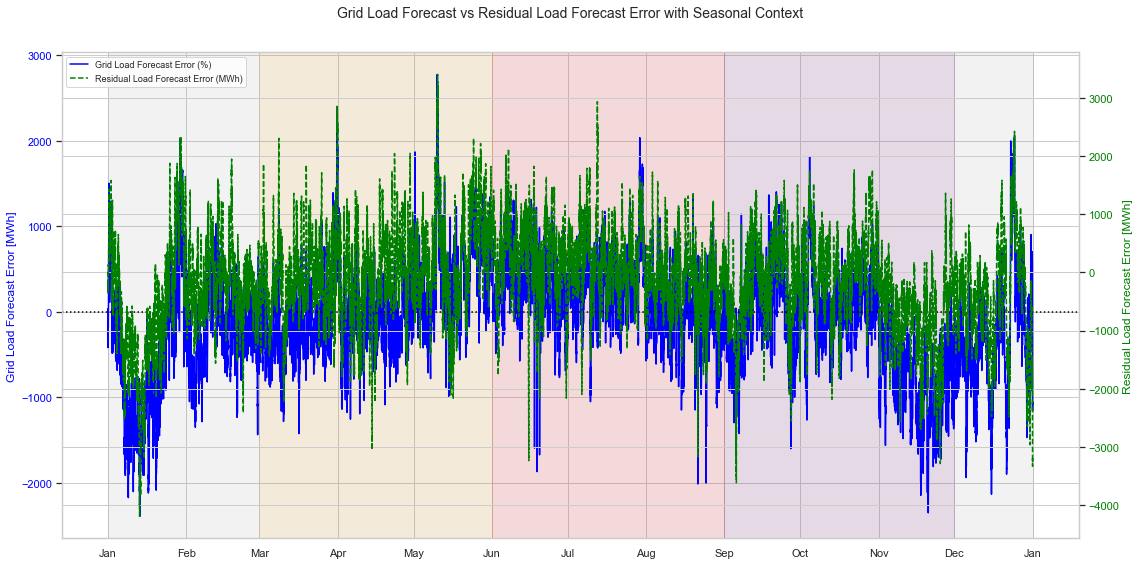

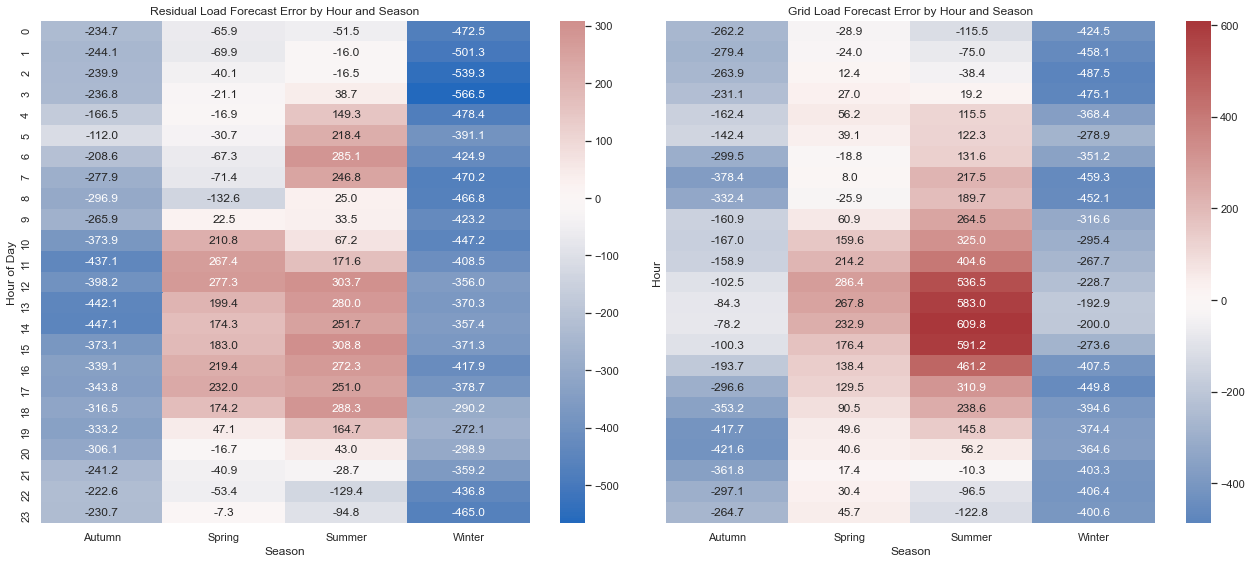

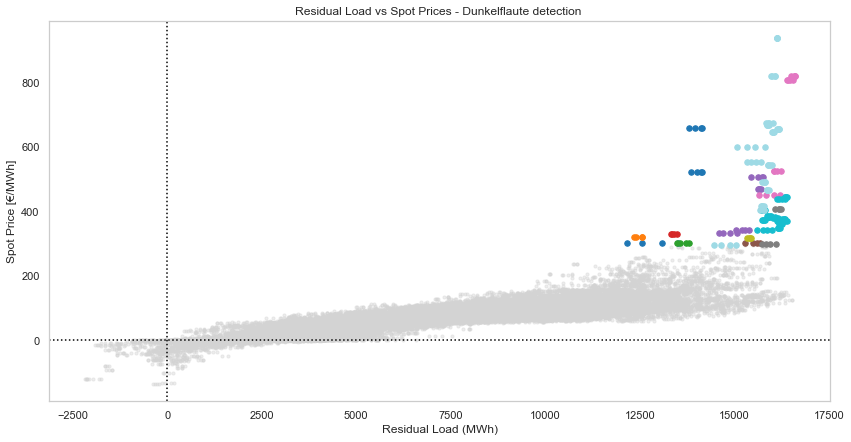


=== Dunkelflaute Event Periods ===

Outlier Cluster 2: 03-Sep-2024 18:00 -> 03-Sep-2024 20:45 | Duration: 2.8 hours | Color: steelblue
Outlier Cluster 4: 04-Sep-2024 19:00 -> 04-Sep-2024 19:45 | Duration: 0.8 hours | Color: darkorange
Outlier Cluster 6: 12-Sep-2024 19:00 -> 12-Sep-2024 19:45 | Duration: 0.8 hours | Color: forestgreen
Outlier Cluster 8: 23-Sep-2024 19:00 -> 23-Sep-2024 19:45 | Duration: 0.8 hours | Color: crimson
Outlier Cluster 10: 05-Nov-2024 16:00 -> 05-Nov-2024 19:45 | Duration: 3.8 hours | Color: mediumpurple
Outlier Cluster 12: 06-Nov-2024 07:00 -> 06-Nov-2024 07:45 | Duration: 0.8 hours | Color: sienna
Outlier Cluster 14: 06-Nov-2024 16:00 -> 06-Nov-2024 19:45 | Duration: 3.8 hours | Color: orchid
Outlier Cluster 16: 07-Nov-2024 17:00 -> 07-Nov-2024 18:45 | Duration: 1.8 hours | Color: grey
Outlier Cluster 18: 12-Nov-2024 17:00 -> 12-Nov-2024 17:45 | Duration: 0.8 hours | Color: goldenrod
Outlier Cluster 20: 11-Dec-2024 08:00 -> 11-Dec-2024 19:45 | Duration: 11.

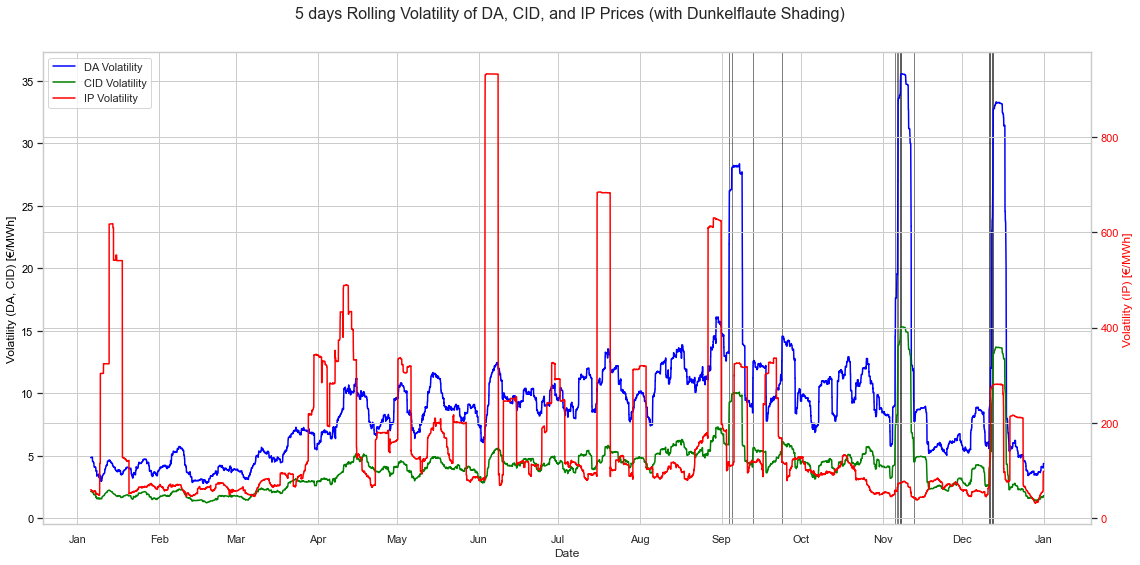

In [2]:
# ===========================================
# LOAD AND DUNKELFLAUTE ANALYSIS
# ===========================================

# ------------------ Start Plot ------------------
fig, ax1 = plt.subplots(figsize=(16, 8))

# Forecast Error on left axis
ax1.plot(df['Start date'], df['Forecast Error'], color='blue', label='Grid Load Forecast Error (%)')
ax1.axhline(0, linestyle='dotted', color='black')
ax1.set_ylabel('Grid Load Forecast Error [MWh]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Residual Load Error on right axis
ax2 = ax1.twinx()
ax2.plot(df['Start date'], df['Residual Load Forecast Error'], color='green', linestyle='--', label='Residual Load Forecast Error (MWh)')
ax2.set_ylabel('Residual Load Forecast Error [MWh]', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Seasonal shading
season_colors = {
    'Winter': 'grey',
    'Spring': 'orange',
    'Summer': 'red',
    'Autumn': 'purple'
}
df['Season'] = df['Start date'].apply(get_season)
for season in df['Season'].unique():
    season_dates = df[df['Season'] == season]
    if not season_dates.empty:
        ax1.axvspan(season_dates['Start date'].min(), season_dates['Start date'].max(),
                    color=season_colors.get(season, '#f0f0f0'), alpha=0.1)

# Formatting
fig.suptitle("Grid Load Forecast vs Residual Load Forecast Error with Seasonal Context", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.90)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=9)

plt.grid(True)
plt.show()

# ---------------------- Plot: Forecast Accuracy by Season & Hour for grid load & residual grid load  ----------------------
df['Season'] = df['Start date'].apply(get_season)

# Pivot data
heatmap_data_residual = df.pivot_table(values='Residual Load Forecast Error', index='Hour', columns='Season', aggfunc='mean')
heatmap_data_grid = df.pivot_table(values='Forecast Error', index='Hour', columns='Season', aggfunc='mean')

# Plot both heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Residual Load Forecast Error
sns.heatmap(heatmap_data_residual, annot=True, fmt=".1f", cmap='vlag', center=0, ax=axes[0])
axes[0].set_title("Residual Load Forecast Error by Hour and Season")
axes[0].set_ylabel("Hour of Day")
axes[0].set_xlabel("Season")

# Grid Load Forecast Error
sns.heatmap(heatmap_data_grid, annot=True, fmt=".1f", cmap='vlag', center=0, ax=axes[1])
axes[1].set_title("Grid Load Forecast Error by Hour and Season")
axes[1].set_xlabel("Season")

plt.tight_layout()
plt.show()

# ---------------------- Plot: Load vs renewables for "Dunkelflaute" opportunity ----------------------
df['Wind + Solar Output (MWh)'] = (
    df['Wind offshore [MWh]'] +
    df['Wind onshore [MWh]'] +
    df['Photovoltaics [MWh]']
)

# --- Calculate Residual Load if not done ---
df['Residual Load (MWh)'] = df['grid load [MWh]'] - df['Wind + Solar Output (MWh)']

# ---------------------- Plot: Residual Load vs Spot Prices ----------------------
# --- Step 1: Set High Outlier Threshold ---
high_threshold = df['DE (MWh euro)'].quantile(0.995) 

# --- Step 2: Detect Only High Outliers ---
df['Is High Outlier'] = df['DE (MWh euro)'] > high_threshold

# --- Step 3: Group Consecutive High Outlier Days ---
df['Date'] = df['Start date'].dt.date
df['Outlier Cluster'] = (df['Is High Outlier'].diff(1) != 0).cumsum()
outlier_clusters = df[df['Is High Outlier']].groupby('Outlier Cluster')

# --- Step 4: Plotting without Crazy Legend ---
plt.figure(figsize=(14, 7))

# Plot normal hours (non-outliers) first
normal_points = df[~df['Is High Outlier']]
plt.scatter(normal_points['Residual load [MWh]'], normal_points['DE (MWh euro)'], 
            color='lightgray', alpha=0.4, s=10)

# Plot each outlier cluster separately
colors = plt.cm.tab20(np.linspace(0, 1, len(outlier_clusters)))

for (cluster_id, cluster_df), color in zip(outlier_clusters, colors):
    plt.scatter(cluster_df['Residual load [MWh]'], cluster_df['DE (MWh euro)'],
                color=color, s=30)

plt.axhline(0, linestyle='dotted', color='black')
plt.axvline(0, linestyle='dotted', color='black')
plt.title('Residual Load vs Spot Prices - Dunkelflaute detection ')
plt.xlabel('Residual Load (MWh)')
plt.ylabel('Spot Price [€/MWh]')
plt.grid()
plt.show()

# --- Step 5: List Dunkelflaute Outlier Date Ranges ---

def closest_color_name(requested_hex):
    requested_rgb = mcolors.to_rgb(requested_hex)
    min_colors = {}
    for name, hex_value in mcolors.CSS4_COLORS.items():
        r_c, g_c, b_c = mcolors.to_rgb(hex_value)
        distance = (r_c - requested_rgb[0])**2 + (g_c - requested_rgb[1])**2 + (b_c - requested_rgb[2])**2
        min_colors[distance] = name
    return min_colors[min(min_colors.keys())]

print("\n=== Dunkelflaute Event Periods ===\n")

# Regenerate the same colors as in the plot
colors = plt.cm.tab20(np.linspace(0, 1, len(outlier_clusters)))
color_hexes = [mcolors.to_hex(c) for c in colors]

for ((cluster_id, cluster_df), color_hex) in zip(outlier_clusters, color_hexes):
    start_time = cluster_df['Start date'].min()
    end_time = cluster_df['Start date'].max()
    duration_hours = (end_time - start_time).total_seconds() / 3600

    color_name = closest_color_name(color_hex)
    print(f"Outlier Cluster {cluster_id}: {start_time:%d-%b-%Y %H:%M} -> {end_time:%d-%b-%Y %H:%M} | "
          f"Duration: {duration_hours:.1f} hours | Color: {color_name}")

# --- Compare Volatility ---
is_dunkelflaute = df['Is High Outlier']
df['Price Return'] = df['DE (MWh euro)'].diff()

# Daily volatility
volatility_normal = df.loc[~is_dunkelflaute, 'Price Return'].std()
volatility_dunkelflaute = df.loc[is_dunkelflaute, 'Price Return'].std()

print("\n===== Volatility Comparison =====")
df['DA Return'] = df['DE (MWh euro)'].diff()
df['CID Return'] = df['DE CID (MWh euro)'].diff()
df['IP Return'] = df['DE IP Price (MWh euro)'].diff()

# Now calculate volatility for each, split by Dunkelflaute vs Normal
volatility = {}

for label, condition in [('Normal', ~df['Is High Outlier']), ('Dunkelflaute', df['Is High Outlier'])]:
    subset = df[condition]
    
    volatility[label] = {
        'DA Volatility': subset['DA Return'].std(),
        'CID Volatility': subset['CID Return'].std(),
        'IP Volatility': subset['IP Return'].std(),
    }

volatility_df = pd.DataFrame(volatility)
print(volatility_df)

# ---------------------- Plot: Wholesale market prices throughout a Dunkelflaute period ----------------------

# Step 1: Compute rolling volatilities if not already done
window = 480  # 1 day if your data is 15-minute intervals 1 = 96 and 2 = 192
df['DA Rolling Vol'] = df['DA Return'].rolling(window=window).std()
df['CID Rolling Vol'] = df['CID Return'].rolling(window=window).std()
df['IP Rolling Vol'] = df['IP Return'].rolling(window=window).std()

# Step 2: Plotting
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot DA and CID on the left y-axis
ax1.plot(df['Start date'], df['DA Rolling Vol'], label='DA Volatility', color='blue')
ax1.plot(df['Start date'], df['CID Rolling Vol'], label='CID Volatility', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility (DA, CID) [€/MWh]', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create second y-axis
ax2 = ax1.twinx()
ax2.plot(df['Start date'], df['IP Rolling Vol'], label='IP Volatility', color='red')
ax2.set_ylabel('Volatility (IP) [€/MWh]', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Background shading for Dunkelflaute
for cluster_id, cluster_df in df[df['Is High Outlier']].groupby('Outlier Cluster'):
    start = cluster_df['Start date'].min()
    end = cluster_df['Start date'].max()
    ax1.axvspan(start, end, color='black', alpha=0.5)

# Axis formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45)

# Titles and legend
fig.suptitle('5 days Rolling Volatility of DA, CID, and IP Prices (with Dunkelflaute Shading)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.90)  # Leave space for title

# Merge legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.grid(True)
plt.show()

<Figure size 1296x720 with 0 Axes>

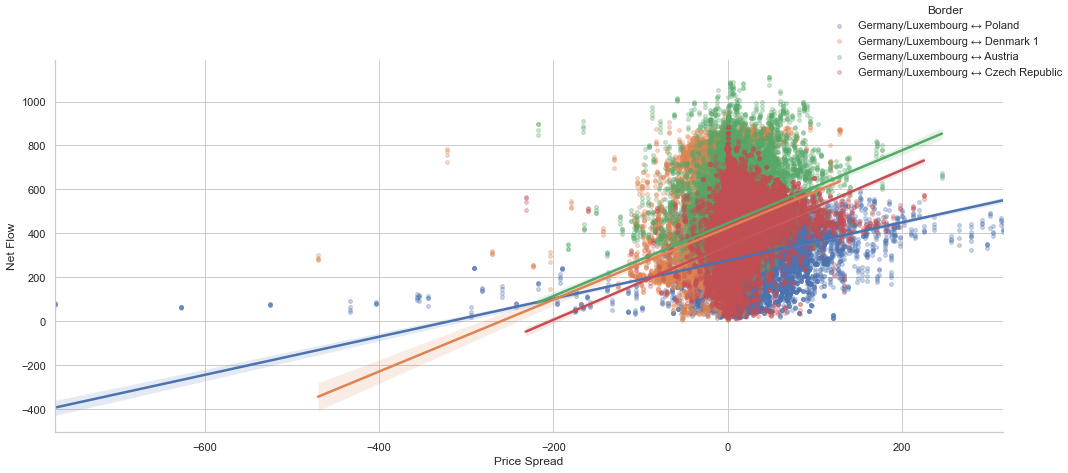

electricity is flowing from low-price (Germany) to high-price neighboring country

Target trades along borders with positive slopes → likely better risk/reward


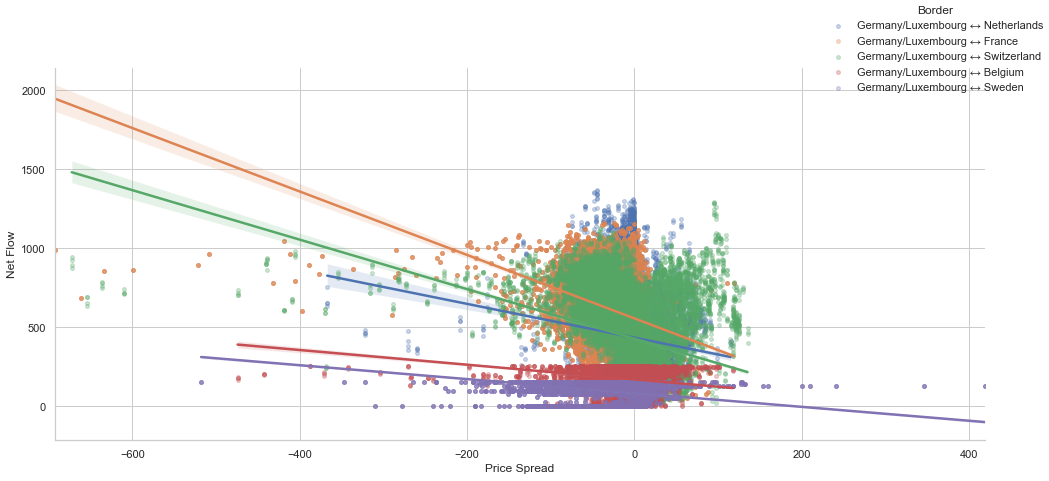

As the price in the other country increases, Germany exports less, or imports more
Inefficient or constrained flow : such as Contractual must-run exports/imports and/or Internal transmission bottlenecks and/or Loop flows (especially in Central Europe)



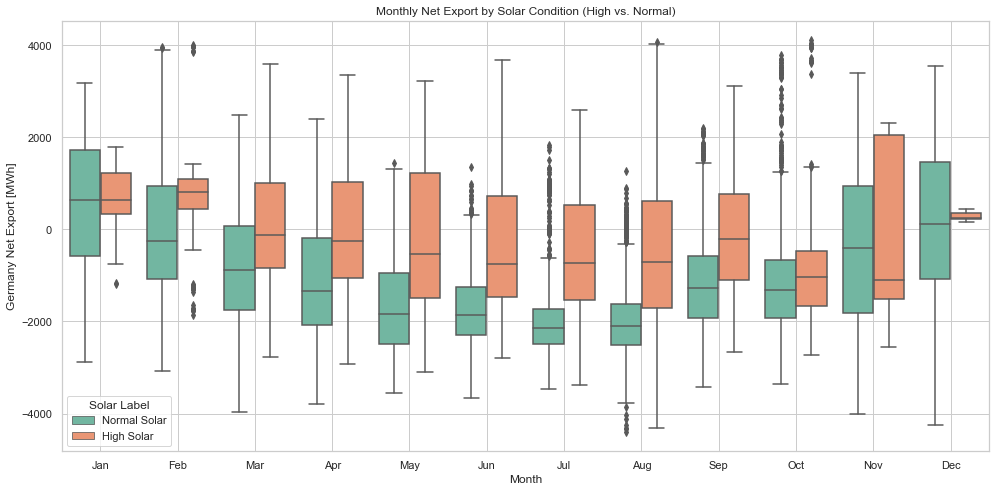

 Net Export on High Solar period:
Mean: -257 MWh | Median: -503 | Std: 1,461
 Net Export on Other Times:
Mean: -818 MWh | Median: -1,128 | Std: 1,531


In [3]:
# ===========================================
# CROSS-BORDER NET POWER FLOW ANALYSIS
# ===========================================

border_pairs = [
    ("Germany/Luxembourg [MWh - euro]", "Netherlands [MWh - euro]", "Netherlands (export) [MWh]", "Netherlands (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "France [MWh - euro]", "France (export) [MWh]", "France (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Poland [MWh - euro]", "Poland (export) [MWh]", "Poland (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Switzerland [MWh - euro]", "Switzerland (export) [MWh]", "Switzerland (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Denmark 1 [MWh - euro]", "Denmark (export) [MWh]", "Denmark (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Belgium [MWh - euro]", "Belgium (export) [MWh]", "Belgium (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Austria [MWh - euro]", "Austria (export) [MWh]", "Austria (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Sweden [MWh - euro]", "Sweden (export) [MWh]", "Sweden (import) [MWh]"),
    ("Germany/Luxembourg [MWh - euro]", "Czech Republic [MWh - euro]", "Czech Republic (export) [MWh]", "Czech Republic (import) [MWh]")
]
correlation_results = []
plt.figure(figsize=(18, 10))
border_data = []
for base, target, export_col, import_col in border_pairs:
    if all(col in df.columns for col in [base, target, export_col, import_col]):
        temp = df.copy()
        temp["Price Spread"] = temp[target] - temp[base]
        temp["Net Flow"] = temp[export_col] - temp[import_col]
        temp["Border"] = f"{base.replace(' [MWh - euro]', '')} ↔ {target.replace(' [MWh - euro]', '')}"
        border_data.append(temp[["Start date", "Price Spread", "Net Flow", "Border"]])
border_df = pd.concat(border_data)
border_slopes = {}
for border in border_df['Border'].unique():
    temp = border_df[border_df['Border'] == border].dropna()
    if len(temp) > 2:
        X = temp[['Price Spread']].values
        y = temp['Net Flow'].values
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        border_slopes[border] = slope
positive_borders = [b for b, s in border_slopes.items() if s > 0]
negative_borders = [b for b, s in border_slopes.items() if s <= 0]
border_df_pos = border_df[border_df['Border'].isin(positive_borders)]
border_df_neg = border_df[border_df['Border'].isin(negative_borders)]

# -------------------------------
# Positive Slope Borders
# -------------------------------
g_pos = sns.lmplot(
    data=border_df_pos,
    x="Price Spread",
    y="Net Flow",
    hue="Border",
    height=6,
    aspect=1.8,
    scatter_kws={"alpha": 0.3, "s": 15},
    line_kws={"linewidth": 2.5}
)
g_pos.fig.subplots_adjust(right=0.75)  # leave space for legend
g_pos._legend.set_bbox_to_anchor((1.05, 1))  # move legend outside
g_pos._legend.set_title("Border")
g_pos.set_titles("Net Flow vs Price Spread — Positive Slope Borders")
plt.tight_layout()
plt.show()

print("electricity is flowing from low-price (Germany) to high-price neighboring country")
print("")
print("Target trades along borders with positive slopes → likely better risk/reward")
# -------------------------------
# Negative Slope Borders
# -------------------------------
g_neg = sns.lmplot(
    data=border_df_neg,
    x="Price Spread",
    y="Net Flow",
    hue="Border",
    height=6,
    aspect=1.8,
    scatter_kws={"alpha": 0.3, "s": 15},
    line_kws={"linewidth": 2.5}
)
g_neg.fig.subplots_adjust(right=0.75)
g_neg._legend.set_bbox_to_anchor((1.05, 1))
g_neg._legend.set_title("Border")
g_neg.set_titles("Net Flow vs Price Spread — Negative Slope Borders")
plt.tight_layout()
plt.show()
print("As the price in the other country increases, Germany exports less, or imports more")
print("Inefficient or constrained flow : such as Contractual must-run exports/imports and/or Internal transmission bottlenecks and/or Loop flows (especially in Central Europe)")
print("")

solar_threshold = df['Photovoltaics [MWh]'].quantile(0.80)
df['High Solar'] = df['Photovoltaics [MWh]'] >= solar_threshold
df['Solar Label'] = df['High Solar'].map({True: 'High Solar', False: 'Normal Solar'})
df['Solar Label'] = df['Solar Label'].astype(str)

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df,
    x='Month',
    y='Germany Net export [MWh]',
    hue='Solar Label',
    palette='Set2'
)
plt.title("Monthly Net Export by Solar Condition (High vs. Normal)")
plt.xlabel("Month")
plt.ylabel("Germany Net Export [MWh]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Summary stats
high = df[df['Solar Label'] == 'High Solar']['Germany Net export [MWh]']
low = df[df['Solar Label'] == 'Normal Solar']['Germany Net export [MWh]']

print(" Net Export on High Solar period:")
print(f"Mean: {high.mean():,.0f} MWh | Median: {high.median():,.0f} | Std: {high.std():,.0f}")
print(" Net Export on Other Times:")
print(f"Mean: {low.mean():,.0f} MWh | Median: {low.median():,.0f} | Std: {low.std():,.0f}")

#valid_pairs = [("Germany/Luxembourg", "Netherlands"),("Germany/Luxembourg", "France"),("Germany/Luxembourg", "Austria"),("Germany/Luxembourg", "Czech Republic"),("Germany/Luxembourg", "Poland"),("Germany/Luxembourg", "Switzerland"),("Germany/Luxembourg", "Denmark 1"),("Germany/Luxembourg", "Denmark 2"),("Germany/Luxembourg", "Belgium"),("Germany/Luxembourg", "Sweden 4"),("France", "Belgium"),("France", "Germany/Luxembourg"),("France", "Switzerland"),("France", "Northern Italy"),("Netherlands", "Belgium"),("Netherlands", "Germany/Luxembourg"),("Netherlands", "Denmark 1"),("Belgium", "France"),("Belgium", "Germany/Luxembourg"),("Belgium", "Netherlands"),("Switzerland", "France"),("Switzerland", "Austria"),("Switzerland", "Northern Italy"),("Switzerland", "Germany/Luxembourg"),("Austria", "Czech Republic"),("Austria", "Germany/Luxembourg"),("Austria", "Switzerland"), ("Austria", "Northern Italy"),("Czech Republic", "Germany/Luxembourg"),("Czech Republic", "Poland"),("Czech Republic", "Austria"),("Poland", "Czech Republic"),("Poland", "Germany/Luxembourg"),("Poland", "Sweden 4"),("Denmark 1", "Sweden 4"),("Denmark 1", "Denmark 2"),("Denmark 1", "Netherlands"),("Denmark 1", "Germany/Luxembourg"),("Denmark 2", "Denmark 1"),("Denmark 2", "Sweden 4"),("Denmark 2", "Germany/Luxembourg"),("Sweden 4", "Germany/Luxembourg"),("Sweden 4", "Poland"),("Sweden 4", "Denmark 1"),("Sweden 4", "Denmark 2"),("Northern Italy", "France"),("Northern Italy", "Switzerland"),("Northern Italy", "Austria"),("Northern Italy", "Slovenia"),("Slovenia", "Northern Italy"), ("Slovenia", "Austria"),("Slovenia", "Hungary"),("Hungary", "Austria"),("Hungary", "Slovenia"),]

/Users/gaetanledu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,40,45,47,48,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



Transition Matrix for France
State_France        Germany > Neighbor  Neighbor > Germany  Neutral
State_France                                                       
Germany > Neighbor               0.975               0.021    0.004
Neighbor > Germany               0.040               0.939    0.021
Neutral                          0.009               0.040    0.951

Transition Matrix for Belgium
State_Belgium       Germany > Neighbor  Neighbor > Germany  Neutral
State_Belgium                                                      
Germany > Neighbor               0.967               0.030    0.003
Neighbor > Germany               0.039               0.941    0.020
Neutral                          0.010               0.047    0.943

Transition Matrix for Poland
State_Poland        Germany > Neighbor  Neighbor > Germany  Neutral
State_Poland                                                       
Germany > Neighbor               0.916               0.056    0.028
Neighbor > Germany       

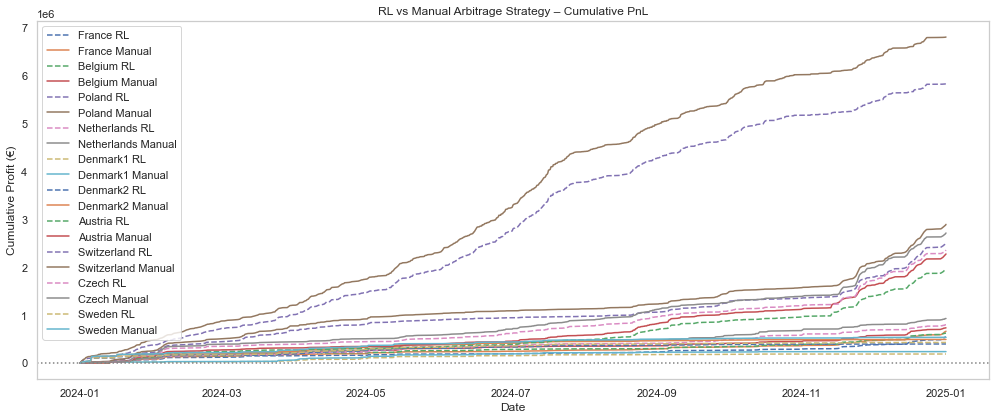


Performance Comparison Table:
             RL Sharpe Ratio  RL Win Rate  Manual Sharpe Ratio  \
France                 0.267       21.536                0.290   
Belgium                0.263       22.772                0.289   
Poland                 0.606       63.735                0.669   
Netherlands            0.283       22.003                0.307   
Denmark1               0.112        3.782                0.130   
Denmark2               0.135        8.478                0.141   
Austria                0.386       37.608                0.420   
Switzerland            0.449       44.669                0.492   
Czech                  0.381       42.686                0.414   
Sweden                 0.139        8.977                0.151   

             Manual Win Rate  
France                26.673  
Belgium               28.256  
Poland                72.265  
Netherlands           26.400  
Denmark1               4.722  
Denmark2              10.198  
Austria               42.

<ipython-input-8-662568aba619>:247: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right')


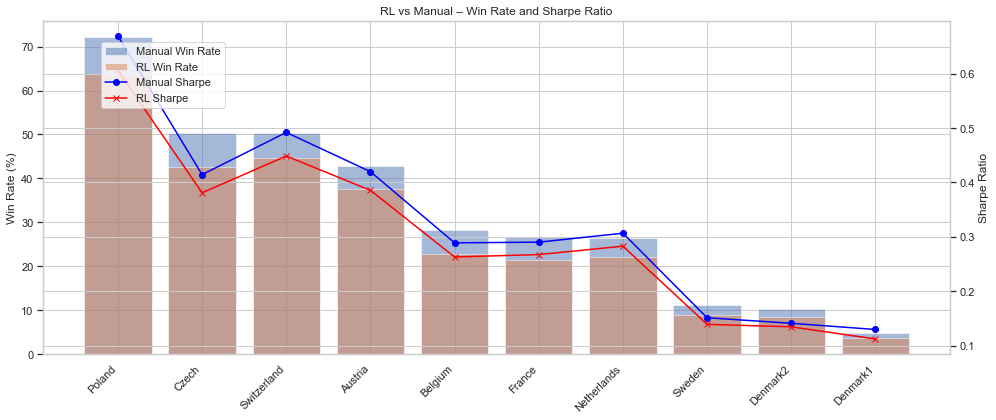


Final Total PnL - RL Strategy: €15,616,663.00
Final Total PnL - Manual Strategy: €18,258,046.00

==================== RL Strategy Summary ====================

Cross-Border Arbitrage with Reinforcement Learning (Q-Learning):

Each neighboring country's spread vs Germany was modeled as a Markov process with 3 regimes:
   - "Germany > Neighbor", "Neighbor > Germany", "Neutral"

The RL agent learned from a composite state combining:
   - Current spread regime
   - Predicted next regime using the Markov transition matrix

Actions available:
   - trade_10MW, trade_5MW, hold

Reward function:
   - Risk-adjusted return = (spread / volatility) * MW * (1 - loss)
   - Penalty applied for poor trades (negative spread conditions)

Strategy incorporated volatility (96-interval rolling window = 1 day at 15-min resolution)

Exploration via epsilon-greedy policy (ε = 0.2), and learned over all time steps




In [8]:
# ===========================================
# CROSS BORDER STRATEGY BETWEEN DE vs NEIGHBORING COUNTRIES USING rule-based arbitrage strategy with Markov chain modeling
# ===========================================

df = pd.read_csv('ALL.csv')  # Update the path to your file
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df.rename(columns={
    "Denmark 1 [MWh - euro]": "Denmark1 [MWh - euro]",
    "Denmark 2 [MWh - euro]": "Denmark2 [MWh - euro]"
}, inplace=True)
neighbors = [
    "France [MWh - euro]", "Belgium [MWh - euro]", "Poland [MWh - euro]",
    "Netherlands [MWh - euro]", "Denmark1 [MWh - euro]", "Denmark2 [MWh - euro]",
    "Austria [MWh - euro]", "Switzerland [MWh - euro]", "Czech Republic [MWh - euro]",
    "Sweden [MWh - euro]"
]
# ---------------------- Spread and Markov State per Country ----------------------
df['Germany_Price'] = df["Germany/Luxembourg [MWh - euro]"]
price_states = ["Germany > Neighbor", "Neighbor > Germany", "Neutral"]
markov_results = {}
for neighbor in neighbors:
    label = neighbor.split()[0]
    df[f"Spread_{label}"] = df[neighbor] - df['Germany_Price']
    df[f"State_{label}"] = pd.cut(df[f"Spread_{label}"], bins=[-np.inf, -2, 2, np.inf], labels=price_states)
    df[f"Volatility_{label}"] = df[f"Spread_{label}"].rolling(window=96).std()
    # Transition Matrix
    transition_counts = pd.crosstab(df[f"State_{label}"].shift(1), df[f"State_{label}"])
    transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
    markov_results[label] = transition_matrix
    
# Optional: Display Transition Matrices
for country, matrix in markov_results.items():
    print(f"\nTransition Matrix for {country}")
    print(matrix.round(3))
# ---------------------- Markov Chain Simulation ----------------------
def simulate_markov_chain(steps, transition_matrix, states=price_states):
    state_sequence = []
    current_state = random.choice(states)
    state_sequence.append(current_state)
    for _ in range(steps - 1):
        current_idx = states.index(current_state)
        probs = transition_matrix.iloc[current_idx].fillna(0).values
        if probs.sum() == 0:
            probs = [1 / len(states)] * len(states)
        next_state = np.random.choice(states, p=probs)
        state_sequence.append(next_state)
        current_state = next_state
    return state_sequence

# ---------------------- Arbitrage Strategy Simulation ----------------------
def simulate_trades(df, neighbors, max_trade_mw=10, loss_percentage=0.05):
    cumulative_pnls = defaultdict(list)
    total_cumulative_pnl = 0
    trade_count = defaultdict(int)
    for neighbor in neighbors:
        label = neighbor.split()[0]
        df[f"PnL_{label}"] = 0
        for idx, row in df.iterrows():
            price_spread = row[f"Spread_{label}"]
            if price_spread > 0:
                price_spread_after_loss = price_spread * (1 - loss_percentage)
                if price_spread_after_loss > 0:
                    df.at[idx, f"PnL_{label}"] = max_trade_mw * price_spread_after_loss
                    trade_count[label] += 1
            cumulative_pnls[label].append(df.at[idx, f"PnL_{label}"])
            total_cumulative_pnl += df.at[idx, f"PnL_{label}"]

    return cumulative_pnls, total_cumulative_pnl, trade_count

# ----------------- 3. Plot Results ----------------- #

# Ensure that the cumulative PnL has the same length as the dates
def plot_cumulative_pnl(cumulative_pnls, df):
    plt.figure(figsize=(10, 5))
    
    # For each country, align the cumulative pnl with the date
    for country, pnl in cumulative_pnls.items():
        # Check if the cumulative pnl has the same length as the date
        if len(pnl) == len(df):
            plt.plot(df["Start date"], np.cumsum(pnl), label=f"{country} Cumulative PnL")
        else:
            print(f"Skipping {country} due to mismatched lengths")
    
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Cumulative PnL for Cross-Border Arbitrage")
    plt.ylabel("Cumulative Profit (€)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
def plot_trade_count(trade_count):
    countries = list(trade_count.keys())
    trade_counts = list(trade_count.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(countries, trade_counts)
    plt.title("Number of Trades with Each Neighboring Country")
    plt.ylabel("Number of Trades")
    plt.xlabel("Countries")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ----------------- 4. Run the Simulation ----------------- #

# Simulate arbitrage strategy
cumulative_pnls, total_cumulative_pnl, trade_count = simulate_trades(df, neighbors)

# ---------------------- Performance Metrics ----------------------
metrics = {}
for country in cumulative_pnls.keys():
    country_cum_pnl = np.cumsum(cumulative_pnls[country])
    country_pnl = df[f"PnL_{country}"]
    returns = np.diff(country_cum_pnl)
    sharpe = (np.mean(returns)) / (np.std(returns)) if np.std(returns) > 1e-6 else np.nan
    winning_trades = country_pnl[country_pnl > 0]
    total_trades = len(country_pnl)
    win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
    metrics[country] = {
        'Sharpe Ratio': sharpe,
        'Win Rate': win_rate * 100
    }
metrics_df = pd.DataFrame(metrics).T

print("""
Summary of Cross-Border Arbitrage Strategy:

1. Price Spread State Transitions:
   - Implementation of a Markov Chain model for price spread dynamics between Germany and its neighboring countries (France, Belgium, Poland, etc.).
   - The transition matrix was calculated based on the historical price spread data, discretizing the price spread into three states: "Germany > Neighbor", "Neighbor > Germany", and "Neutral".

2. Arbitrage Strategy Simulation:
   - I simulated cross-border arbitrage strategies based on price spreads between Germany and its neighbors.
   - Implementation of a reinforcement learning model to optimize trading strategies, considering factors like transmission losses and profitability.
   - Trades are only executed when the spread, after accounting for transmission loss (5%), is positive and profitable.
   - A maximum trade size of 10 MW is applied per 15-minute interval.
""")

# ===========================================
# CROSS BORDER STRATEGY BETWEEN DE vs NEIGHBORING COUNTRIES USING Markov chain modeling AND Q-Learning RL Strategy
# ===========================================

# ---------------------- Q-Learning RL Strategy for All Neighbors ----------------------
actions = ['trade_10MW', 'trade_5MW', 'hold']
alpha = 0.1
gamma = 0.9
epsilon = 0.2
rl_cumulative_pnls = {}
manual_cumulative_pnls = {}
rl_metrics = {}
manual_metrics = {}

for i, neighbor in enumerate(neighbors):
    label = neighbor.split()[0]
    print(f"Running enhanced RL for {label} ({i + 1}/{len(neighbors)})...")

    q_table = pd.DataFrame(columns=actions)
    df[f"PnL_{label}_RL"] = 0
    df[f"PnL_{label}_Manual"] = 0

    for t in range(1, len(df)):
        state = df[f"State_{label}"].iloc[t - 1]
        next_state = df[f"State_{label}"].iloc[t]
        spread = df[f"Spread_{label}"].iloc[t]
        vol = df[f"Volatility_{label}"].iloc[t] if f"Volatility_{label}" in df.columns and pd.notna(df[f"Volatility_{label}"].iloc[t]) else 1

        # Predict next regime using Markov
        predicted_state = markov_results[label].loc[state].idxmax() if state in markov_results[label].index else state
        composite_state = f"{state}->{predicted_state}"

        # Initialize Q-table entry
        if composite_state not in q_table.index:
            q_table.loc[composite_state] = pd.Series({a: 0.0 for a in actions})

        # Choose action
        action = np.random.choice(actions) if np.random.rand() < epsilon else q_table.loc[composite_state].idxmax()

        # Reward based on action
        if spread > 0:
            if action == 'trade_10MW':
                reward = (spread / vol) * 10 * 0.95
                df.at[t, f"PnL_{label}_RL"] = spread * 10 * 0.95
            elif action == 'trade_5MW':
                reward = (spread / vol) * 5 * 0.95
                df.at[t, f"PnL_{label}_RL"] = spread * 5 * 0.95
            else:
                reward = 0
        else:
            reward = -5  # penalize for bad spread

        # Update Q-table
        future_q = q_table.loc[composite_state].max()
        q_table.loc[composite_state, action] += alpha * (reward + gamma * future_q - q_table.loc[composite_state, action])

        # Manual rule
        if spread > 0:
            df.at[t, f"PnL_{label}_Manual"] = spread * 10 * 0.95

    df[f"Cumulative_PnL_{label}_RL"] = df[f"PnL_{label}_RL"].cumsum()
    df[f"Cumulative_PnL_{label}_Manual"] = df[f"PnL_{label}_Manual"].cumsum()

    rl_cumulative_pnls[label] = df[f"Cumulative_PnL_{label}_RL"]
    manual_cumulative_pnls[label] = df[f"Cumulative_PnL_{label}_Manual"]

    rl_returns = np.diff(df[f"Cumulative_PnL_{label}_RL"].fillna(0))
    rl_sharpe = np.mean(rl_returns) / np.std(rl_returns) if np.std(rl_returns) > 1e-6 else np.nan
    rl_win_rate = (df[f"PnL_{label}_RL"] > 0).mean() * 100
    rl_metrics[label] = {'Sharpe Ratio': rl_sharpe, 'Win Rate': rl_win_rate}

    manual_returns = np.diff(df[f"Cumulative_PnL_{label}_Manual"].fillna(0))
    manual_sharpe = np.mean(manual_returns) / np.std(manual_returns) if np.std(manual_returns) > 1e-6 else np.nan
    manual_win_rate = (df[f"PnL_{label}_Manual"] > 0).mean() * 100
    manual_metrics[label] = {'Sharpe Ratio': manual_sharpe, 'Win Rate': manual_win_rate}

# ---------------------- Plot: RL vs Manual Strategy ----------------------
plt.figure(figsize=(14, 6))
for label in rl_cumulative_pnls:
    plt.plot(df['Start date'], rl_cumulative_pnls[label], linestyle='--', label=f'{label} RL')
    plt.plot(df['Start date'], manual_cumulative_pnls[label], linestyle='-', label=f'{label} Manual')

plt.axhline(0, color='gray', linestyle=':')
plt.title("RL vs Manual Arbitrage Strategy – Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit (€)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------------------- Summary Table ----------------------
rl_df = pd.DataFrame(rl_metrics).T.rename(columns=lambda x: f"RL {x}")
manual_df = pd.DataFrame(manual_metrics).T.rename(columns=lambda x: f"Manual {x}")
comparison_df = pd.concat([rl_df, manual_df], axis=1)
print("\nPerformance Comparison Table:")
print(comparison_df.round(3))

# ---------------------- Plot: Sharpe Ratio and Win Rate ----------------------
fig, ax1 = plt.subplots(figsize=(14, 6))
comparison_df = comparison_df.sort_values(by='Manual Win Rate', ascending=False)

# Win Rate Bar
ax1.bar(comparison_df.index, comparison_df['Manual Win Rate'], alpha=0.5, label='Manual Win Rate')
ax1.bar(comparison_df.index, comparison_df['RL Win Rate'], alpha=0.5, label='RL Win Rate')
ax1.set_ylabel("Win Rate (%)")
ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right')

# Sharpe Ratio Line
ax2 = ax1.twinx()
ax2.plot(comparison_df.index, comparison_df['Manual Sharpe Ratio'], label='Manual Sharpe', color='blue', marker='o')
ax2.plot(comparison_df.index, comparison_df['RL Sharpe Ratio'], label='RL Sharpe', color='red', marker='x')
ax2.set_ylabel("Sharpe Ratio")

# Titles and Legends
plt.title("RL vs Manual – Win Rate and Sharpe Ratio")
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()

# ---------------------- Print Final PnL ----------------------
final_pnl_rl = sum(df[f"PnL_{label}_RL"].sum() for label in rl_cumulative_pnls)
final_pnl_manual = sum(df[f"PnL_{label}_Manual"].sum() for label in manual_cumulative_pnls)
print("\n====================")
print(f"Final Total PnL - RL Strategy: €{final_pnl_rl:,.2f}")
print(f"Final Total PnL - Manual Strategy: €{final_pnl_manual:,.2f}")
print("====================")

print("""
==================== RL Strategy Summary ====================

Cross-Border Arbitrage with Reinforcement Learning (Q-Learning):

Each neighboring country's spread vs Germany was modeled as a Markov process with 3 regimes:
   - "Germany > Neighbor", "Neighbor > Germany", "Neutral"

The RL agent learned from a composite state combining:
   - Current spread regime
   - Predicted next regime using the Markov transition matrix

Actions available:
   - trade_10MW, trade_5MW, hold

Reward function:
   - Risk-adjusted return = (spread / volatility) * MW * (1 - loss)
   - Penalty applied for poor trades (negative spread conditions)

Strategy incorporated volatility (96-interval rolling window = 1 day at 15-min resolution)

Exploration via epsilon-greedy policy (ε = 0.2), and learned over all time steps

==============================================================
""")



/Users/gaetanledu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,40,45,47,48,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


[LightGBM] [Info] Number of positive: 1462, number of negative: 26570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 28032, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052155 -> initscore=-2.899977
[LightGBM] [Info] Start training from score -2.899977

===== LightGBM Classification Report =====

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6642
           1       0.91      0.86      0.88       366

    accuracy                           0.99      7008
   macro avg       0.95      0.93      0.94      7008
weighted avg       0.99      0.99      0.99      7008



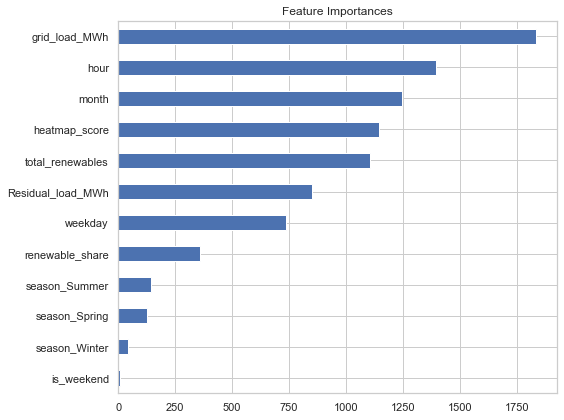

Average flow per year for each countries - checking that the net flow is well considered
France → Mean: 595.60, Unique: 31751
Belgium → Mean: 172.59, Unique: 23907
Poland → Mean: 288.56, Unique: 29432
Netherlands → Mean: 432.67, Unique: 31803
Austria → Mean: 449.25, Unique: 30530
Switzerland → Mean: 429.63, Unique: 31913
Sweden → Mean: 95.52, Unique: 17810

The net flow adjust on a daily basis according to the previous day net flow - keep it quite realistic

STRATEGY LOGIC:
Leverage negative DA electricity prices in Germany by buying excess power (negative power price) and then reselling it to neighboring countries where prices are positive
I forecast the potential of negative power price using LightGBM classifier: Expect negative DA price '1' or No trade '0'
Formula = Neighbor Price−German Price−Execution Cost
PnL logic = Spread×Available Capacity

Notes:
------
- Negative price days are highly profitable for cross-border trading.
- The model (LightGBM) predicts binary classification:

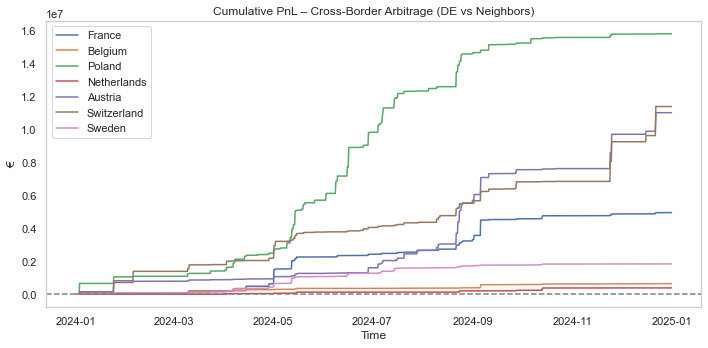


===== Scaled PnL Estimates (Cross-Border Strategy) =====

                neighbor  scaled_pnl (€)  avg_flow (MWh/15min)  total_trades
     Poland [MWh - euro]     15785038.86                288.56          1357
Switzerland [MWh - euro]     11378268.64                429.63          1357
    Austria [MWh - euro]     11004214.50                449.25          1357
     France [MWh - euro]      4948026.98                595.60          1357
     Sweden [MWh - euro]      1840080.63                 95.52          1357
    Belgium [MWh - euro]       644953.99                172.59          1357
Netherlands [MWh - euro]       386182.28                432.67          1357

===== Optimized Cross-Border Strategy Results =====

 threshold    neighbor  scaled_pnl (€)  flow (MWh/15min)  total_trades  trades/day
      0.90     Austria       370283.66               750          1357        3.72
      0.80     Austria       363478.47               750          1591        4.36
      0.70      Poland

In [26]:
# ===========================================
# CROSS-BORDER ARBITRAGE STRATEGY (Negative DA Price Focus)
# ===========================================

# ---------------------- Reload Data for Fresh Start ----------------------
df = pd.read_csv(ALL_PATH)
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df.columns = df.columns.str.encode('ascii', 'ignore').str.decode('ascii')
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()
df["Start date"] = pd.to_datetime(df["Start date"], format="%m/%d/%y %H:%M")
df["hour"] = df["Start date"].dt.hour
df["weekday"] = df["Start date"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["month"] = df["Start date"].dt.month
df["season"] = df["Start date"].apply(get_season)
df = pd.get_dummies(df, columns=["season"], drop_first=True)
df["is_negative_price"] = (df["DE (MWh euro)"] < 0).astype(int)
df["total_renewables"] = df[[
    "Wind onshore [MWh]", "Wind offshore [MWh]", "Photovoltaics [MWh]"
]].sum(axis=1)
df["renewable_share"] = df["total_renewables"] / df["grid load [MWh]"]

# Heatmap logic for forecast scores
forecast_cols = [
    "DA Wind onshore [MWh] forecast", "DA Wind offshore [MWh] forecast",
    "DA Photovoltaics [MWh] forecast", "DA Other [MWh] forecast"
]
df[forecast_cols] = df[forecast_cols].apply(pd.to_numeric, errors='coerce')
df["DA_renewable_forecast"] = df[forecast_cols].sum(axis=1)
df["renewable_share_bin"] = (df["renewable_share"] * 100).round().clip(1, 100)
df["DA_renewable_forecast_bin"] = (df["DA_renewable_forecast"] // 1000 * 1000).clip(500, 18000)

heatmap_data = df.pivot_table(
    index="DA_renewable_forecast_bin",
    columns="renewable_share_bin",
    values="is_negative_price",
    aggfunc="mean"
).fillna(0)

df["heatmap_score"] = df.apply(
    lambda row: heatmap_data.loc[row["DA_renewable_forecast_bin"], row["renewable_share_bin"]]
    if row["DA_renewable_forecast_bin"] in heatmap_data.index and row["renewable_share_bin"] in heatmap_data.columns else 0.0,
    axis=1
)

# ===========================================
# TRAIN LIGHTGBM MODEL TO PREDICT NEGATIVE DA PRICES
# ===========================================
df = df.replace([np.inf, -np.inf], np.nan).dropna()
features = [
    "hour", "weekday", "is_weekend", "month", "total_renewables", "renewable_share",
    "Residual load [MWh]", "grid load [MWh]",
    "season_Spring", "season_Summer", "season_Winter", "heatmap_score"]
X = df[features].copy()
X.columns = X.columns.str.replace(r"[\[\]<>]", "", regex=True).str.replace(" ", "_")
y = df["is_negative_price"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
model = LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)
print("\n===== LightGBM Classification Report =====\n")
print(classification_report(y_test, model.predict(X_test)))
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(8, 6), title="Feature Importances")
plt.tight_layout()
plt.show()

# ===========================================
# CROSS-BORDER ARBITRAGE STRATEGY SIMULATION
# ===========================================

# ---------------------- Prediction ----------------------
df["pred_prob"] = model.predict_proba(X)[:, 1]
df["pred_signal"] = (df["pred_prob"] > 0.9).astype(int)

# Neighboring markets
neighbors = [
    "France [MWh - euro]", "Belgium [MWh - euro]", "Poland [MWh - euro]",
    "Netherlands [MWh - euro]", "Austria [MWh - euro]", "Switzerland [MWh - euro]",
    "Sweden [MWh - euro]"
]

label_map = {
    "France": "France",
    "Belgium": "Belgium",
    "Poland": "Poland",
    "Netherlands": "Netherlands",
    "Austria": "Austria",
    "Switzerland": "Switzerland",
    "Sweden": "Sweden"
}

#flows = {"France": 500, "Belgium": 375, "Poland": 250, "Netherlands": 625, "Denmark 1": 200, "Austria": 750, "Switzerland": 450, "Czech": 250, "Sweden": 75}

# ---------------------- PnL Computation ----------------------
pnl_df = []
execution_cost = 1 #€/MWh to account for bid-ask spread or market access cost
for neighbor in neighbors:
    label = neighbor.split()[0]
    full_label = label_map[label]  # Long label to match column names
    df[f"Spread_{label}"] = df[neighbor] - df["DE (MWh euro)"] - execution_cost
    export_col = f"{full_label} (export) [MWh]"
    import_col = f"{full_label} (import) [MWh]"
    if export_col in df.columns and import_col in df.columns:
        df[export_col] = pd.to_numeric(df[export_col], errors="coerce")
        df[import_col] = pd.to_numeric(df[import_col], errors="coerce")
        df[f"Net_Flow_{label}"] = df[export_col] - df[import_col]
        df[f"Available_Capacity_{label}"] = (
            df[f"Net_Flow_{label}"]
            .rolling(window=96)
            .mean()
            .clip(lower=0)
            .fillna(0)
        )
    else:
        df[f"Available_Capacity_{label}"] = 250  # fallback

    # Realistic trade mask: signal at t-1, trade at t, only if spread > 0
    df[f"Trade_Mask_{label}"] = (df["pred_signal"].shift(1) == 1) & (df[f"Spread_{label}"] > 0)

    # Calculate PnL: only apply spread * volume when trade mask is True
    df[f"PnL_{label}"] = df[f"Trade_Mask_{label}"] * df[f"Spread_{label}"]
    df[f"ScaledPnL_{label}"] = df[f"PnL_{label}"] * df[f"Available_Capacity_{label}"]
    df[f"Cumulative_{label}"] = df[f"ScaledPnL_{label}"].cumsum()

    pnl_df.append({
        "neighbor": neighbor,
        "scaled_pnl (€)": round(df[f"ScaledPnL_{label}"].sum(), 2),
        "avg_flow (MWh/15min)": round(df[f"Available_Capacity_{label}"].mean(), 2),
        "total_trades": int(df["pred_signal"].sum())
    })
    
print("Average flow per year for each countries - checking that the net flow is well considered")
for neighbor in neighbors:
    label = neighbor.split(" [")[0]
    capacity_col = f"Available_Capacity_{label}"
    
    if capacity_col in df.columns:
        print(f"{label} → Mean: {df[capacity_col].mean():.2f}, Unique: {df[capacity_col].nunique()}")
print("")
print("The net flow adjust on a daily basis according to the previous day net flow - keep it quite realistic")
print("")
print("STRATEGY LOGIC:")
print("Leverage negative DA electricity prices in Germany by buying excess power (negative power price) and then reselling it to neighboring countries where prices are positive")
print("I forecast the potential of negative power price using LightGBM classifier: Expect negative DA price '1' or No trade '0'")
print("Formula = Neighbor Price−German Price−Execution Cost")
print("PnL logic = Spread×Available Capacity")
print("""
Notes:
------
- Negative price days are highly profitable for cross-border trading.
- The model (LightGBM) predicts binary classification: 'negative price' or 'not'.
- Does not directly predict price level (use LSTM model separately for full regression forecast).
""")



# ---------------------- Plot Cumulative PnL ----------------------
plt.figure(figsize=(10, 5))
for neighbor in neighbors:
    label = neighbor.split()[0]
    plt.plot(df["Start date"], df[f"Cumulative_{label}"], label=label)

plt.axhline(0, color="gray", linestyle="--")
plt.title("Cumulative PnL – Cross-Border Arbitrage (DE vs Neighbors)")
plt.ylabel("€")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------------------- Show Scaled PnL Summary ----------------------
pnl_summary = pd.DataFrame(pnl_df).sort_values(by="scaled_pnl (€)", ascending=False)
print("\n===== Scaled PnL Estimates (Cross-Border Strategy) =====\n")
print(pnl_summary.to_string(index=False))

# ===========================================
# THRESHOLD OPTIMIZATION FOR CROSS-BORDER STRATEGY
# ===========================================

results = []
for threshold in [0.7, 0.8, 0.9, 0.95]:
    df["signal"] = (df["pred_prob"] > threshold).astype(int)
    total_trades = df["signal"].sum()
    trades_per_day = round(total_trades / df["Start date"].dt.date.nunique(), 2)
    
    for neighbor in neighbors:
        label = neighbor.split()[0]
        spread = df[f"Spread_{label}"]
        df[f"filtered_signal_{label}"] = df["signal"] * (spread.abs() > 5)
        flow = flows.get(label, 250)
        df[f"PnL_prob_weighted_{label}_{threshold}"] = (
            df[f"filtered_signal_{label}"].shift(1) * spread.diff() * flow * df["pred_prob"]
        )
        results.append({
            "threshold": threshold,
            "neighbor": label,
            "scaled_pnl (€)": df[f"PnL_prob_weighted_{label}_{threshold}"].sum().round(2),
            "flow (MWh/15min)": flow,
            "total_trades": int(total_trades),
            "trades/day": trades_per_day
        })
opt_df = pd.DataFrame(results).sort_values(by="scaled_pnl (€)", ascending=False)
print("\n===== Optimized Cross-Border Strategy Results =====\n")
print(opt_df.to_string(index=False))



/Users/gaetanledu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,40,45,47,48,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


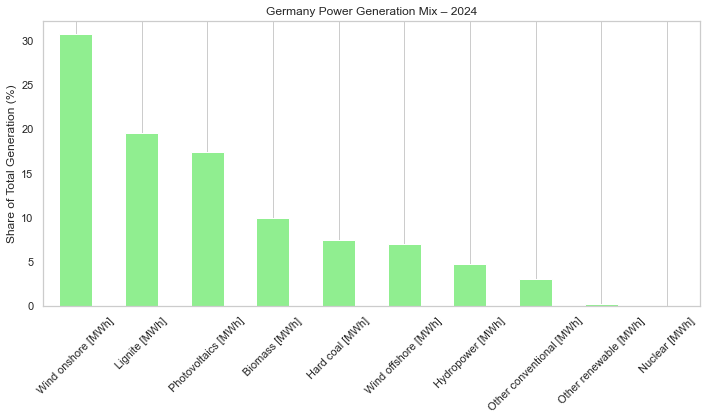

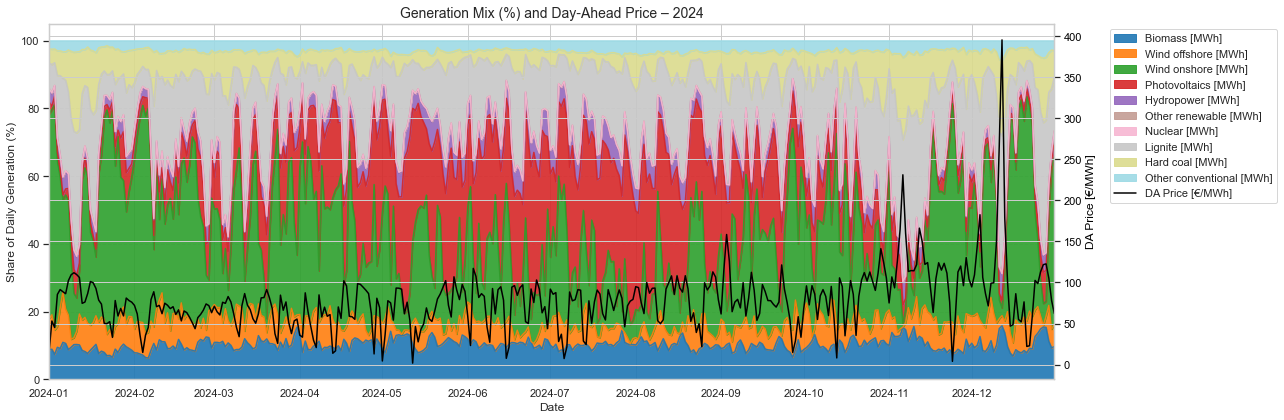

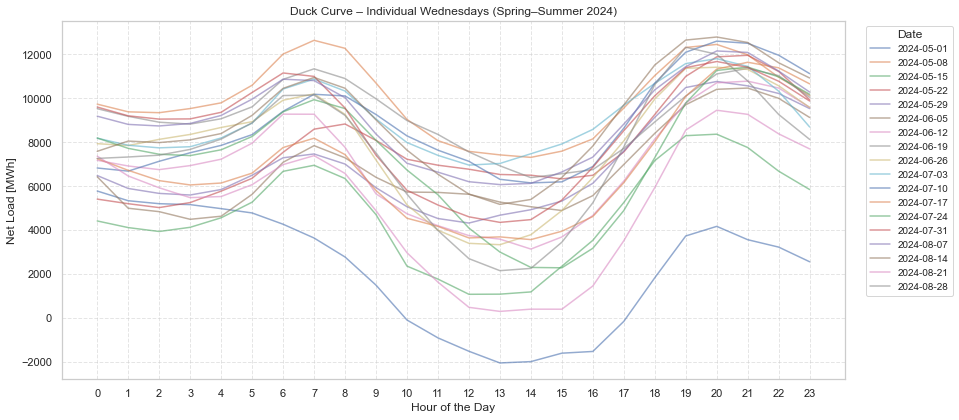

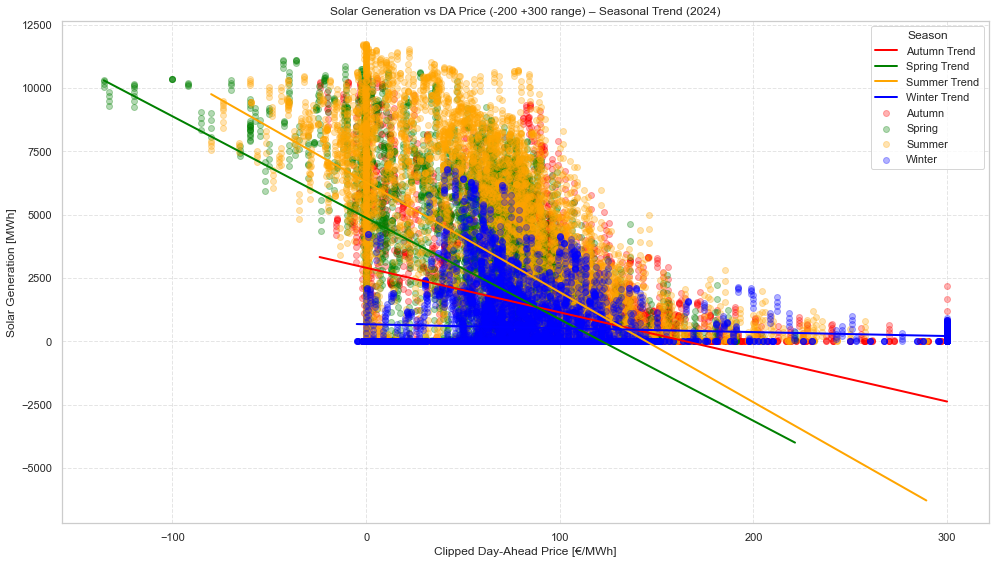

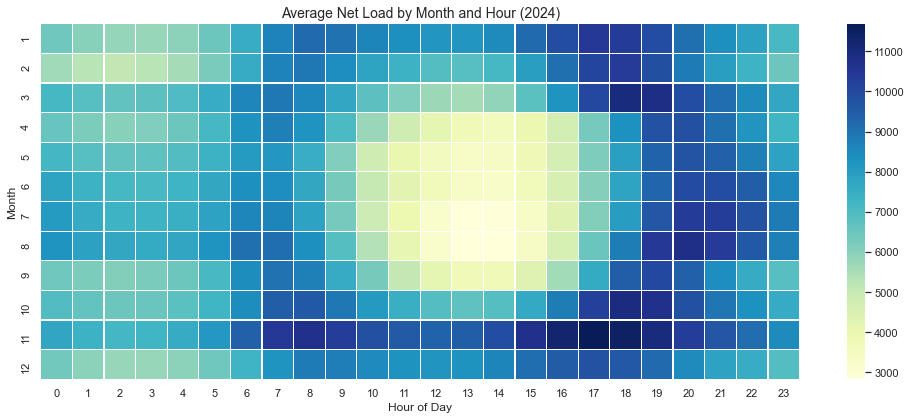

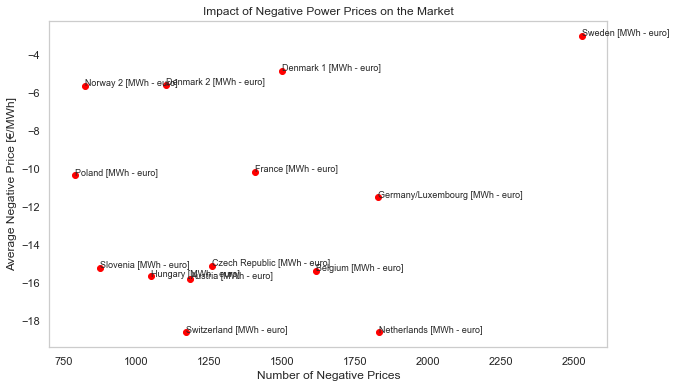

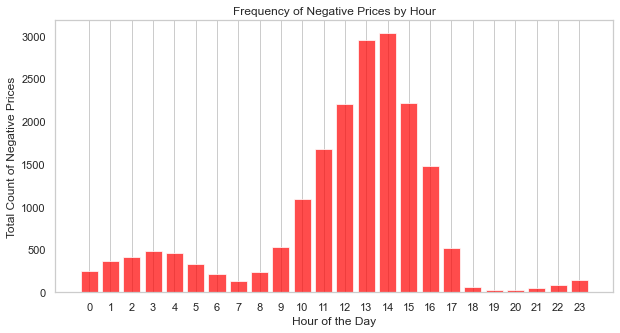

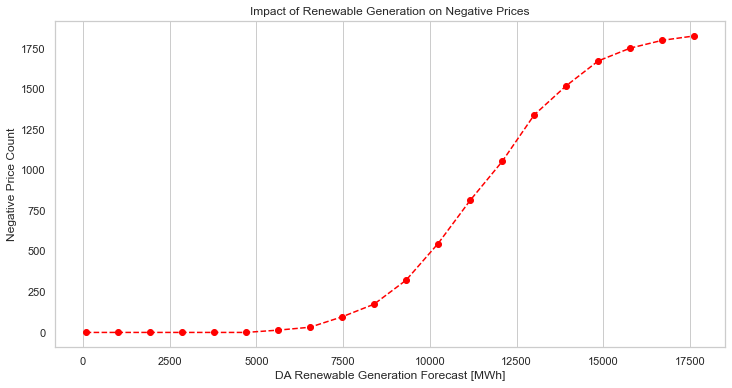

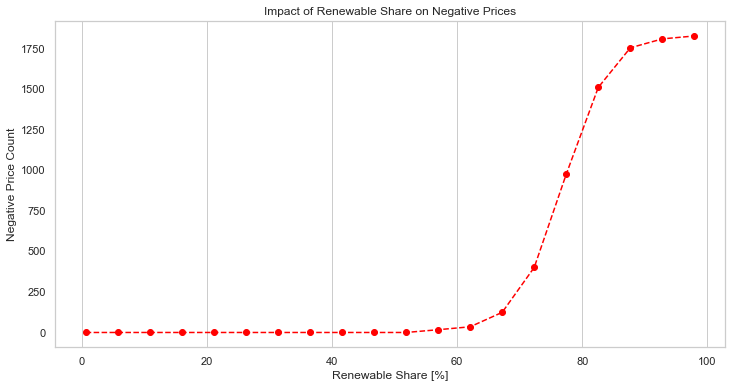

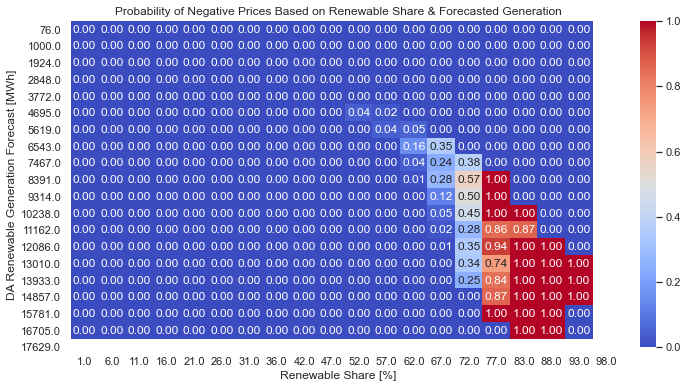

A significant increase in the share of renewables leads to a sharp increase in the occurrence of negative power prices.
Specifically, when renewable energy share exceeds approximately 75% of the total mix, the probability of negative prices reaches close to 100%.
This highlights the importance of flexible resources like batteries, demand response, and dynamic cross-border flows in future electricity markets.


In [81]:
# ===========================================
# RENEWABLE ANALYSIS
# ===========================================

# Parse datetime correctly
df = pd.read_csv('ALL.csv')  # Update the path to your file
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce', format="%m/%d/%y %H:%M")

# Filter year 2024
df_2024 = df[df['Start date'].dt.year == 2024].copy()

# Define generation columns (keep only existing ones)
generation_cols = [
    "Biomass [MWh]", "Wind offshore [MWh]", "Wind onshore [MWh]",
    "Photovoltaics [MWh]", "Hydropower [MWh]", "Other renewable [MWh]",
    "Nuclear [MWh]", "Lignite [MWh]", "Hard coal [MWh]", "Other conventional [MWh]"
]
generation_cols = [col for col in generation_cols if col in df_2024.columns]

# Sort by time and set index
df_2024.sort_values("Start date", inplace=True)
df_2024.set_index("Start date", inplace=True)

# Convert to numeric + interpolate
for col in generation_cols:
    df_2024[col] = pd.to_numeric(df_2024[col], errors='coerce')
    df_2024[col] = df_2024[col].interpolate(method='time')

# Create date-only column
df_2024["date"] = pd.to_datetime(df_2024.index.date)

# ---------------------- Total annual generation per source ----------------------
total_gen = df_2024[generation_cols].sum()
percent_share = (total_gen / total_gen.sum() * 100).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
percent_share.plot(kind="bar", color="lightgreen")
plt.title("Germany Power Generation Mix – 2024")
plt.ylabel("Share of Total Generation (%)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ---------------------- Total annual generation per source with day ahead price----------------------
# Daily generation mix
daily_generation = df_2024.groupby("date")[generation_cols].sum()
daily_percent = daily_generation.div(daily_generation.sum(axis=1), axis=0) * 100

# Daily average DA price
daily_prices = df_2024.groupby("date")["DE (MWh euro)"].mean()

# Plot generation mix and DA price
fig, ax1 = plt.subplots(figsize=(18, 6))

daily_percent.plot.area(stacked=True, cmap="tab20", alpha=0.9, ax=ax1)
ax1.set_ylabel("Share of Daily Generation (%)", fontsize=12)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_title("Generation Mix (%) and Day-Ahead Price – 2024", fontsize=14)
ax1.grid(True, axis="y", linestyle="--", alpha=0.6)

# Format x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Overlay DA prices on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(daily_prices.index, daily_prices.values, color="black", linewidth=1.5, label="DA Price [€/MWh]")
ax2.set_ylabel("DA Price [€/MWh]", fontsize=12, color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

df["Start date"] = pd.to_datetime(df["Start date"], errors="coerce")
df["total_renewables"] = df[["Wind onshore [MWh]", "Wind offshore [MWh]", "Photovoltaics [MWh]"]].sum(axis=1)
df["weekday"] = df["Start date"].dt.weekday
df["month"] = df["Start date"].dt.month
df["hour"] = df["Start date"].dt.hour
df["date_only"] = df["Start date"].dt.date
mask = (
    (df["Start date"].dt.year == 2024) &
    (df["weekday"] == 2) &  # Wednesday
    (df["month"].between(5, 8))) #months with high renewable power generation. 
wednesday_df = df[mask].copy()
wednesday_df["net_load"] = pd.to_numeric(wednesday_df["grid load [MWh]"], errors="coerce") - \
                            pd.to_numeric(wednesday_df["total_renewables"], errors="coerce")
pivot_df = wednesday_df.pivot_table(index="hour", columns="date_only", values="net_load")
plt.figure(figsize=(12, 6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], label=str(col), alpha=0.6)
plt.title("Duck Curve – Individual Wednesdays (Spring–Summer 2024)")
plt.xlabel("Hour of the Day")
plt.ylabel("Net Load [MWh]")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.legend(title="Date", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize="small")
plt.show()

# Add season column
df["season"] = df["Start date"].apply(get_season)
df["solar_gen"] = pd.to_numeric(df["Photovoltaics [MWh]"], errors="coerce")
df["da_price"] = pd.to_numeric(df["DE (MWh euro)"], errors="coerce")
seasonal_df = df.dropna(subset=["solar_gen", "da_price", "season"])
seasonal_df["da_price_clipped"] = seasonal_df["da_price"].clip(lower=-200, upper=300)
plt.figure(figsize=(14, 8))
colors = {"Winter": "blue", "Spring": "green", "Summer": "orange", "Autumn": "red"}
for season, group in seasonal_df.groupby("season"):
    X = group["da_price_clipped"].values.reshape(-1, 1)
    y = group["solar_gen"].values
    plt.scatter(X, y, label=season, alpha=0.3, color=colors[season])
    model = LinearRegression()
    model.fit(X, y)
    x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)
    plt.plot(x_line, y_line, color=colors[season], linewidth=2, label=f"{season} Trend")

plt.title("Solar Generation vs DA Price (-200 +300 range) – Seasonal Trend (2024)")
plt.xlabel("Clipped Day-Ahead Price [€/MWh]")
plt.ylabel("Solar Generation [MWh]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Season")
plt.tight_layout()
plt.show()

# Make sure datetime features are parsed
df["Start date"] = pd.to_datetime(df["Start date"], errors="coerce")
df["month"] = df["Start date"].dt.month
df["hour"] = df["Start date"].dt.hour
df["total_renewables"] = df[["Wind onshore [MWh]", "Wind offshore [MWh]", "Photovoltaics [MWh]"]].sum(axis=1)
df["net_load"] = pd.to_numeric(df["grid load [MWh]"], errors='coerce') - df["total_renewables"]

# Pivot: Hour on X, Month on Y
heatmap_data = df.pivot_table(index="month", columns="hour", values="net_load", aggfunc="mean")

# Plot
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, linewidths=0.2)
plt.title("Average Net Load by Month and Hour (2024)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

# ===========================================
# RENEWABLE GENERATION IMPACT ON NEGATIVE PRICES
# ===========================================

df['Hour'] = df['Start date'].dt.hour

da_price_columns = [col for col in df.columns if '[MWh - euro]' in col]
da_price_columns_clean = [col.replace(' [MWh - euro]', '') for col in da_price_columns]
da_prices = df[da_price_columns].copy()

# Negative prices analysis
negative_prices = (da_prices < 0).sum()
avg_negative_prices = da_prices[da_prices < 0].mean()

negative_prices = negative_prices[negative_prices > 0]
avg_negative_prices = avg_negative_prices.dropna()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(negative_prices, avg_negative_prices, color='red')
plt.title("Impact of Negative Power Prices on the Market")
plt.xlabel("Number of Negative Prices")
plt.ylabel("Average Negative Price [€/MWh]")
for country in negative_prices.index:
    plt.annotate(country, (negative_prices[country], avg_negative_prices[country]), fontsize=9)
plt.grid()
plt.show()

# Bar plot: Negative prices by hour
neg_price_by_hour = (da_prices < 0).sum(axis=1).groupby(df['Hour']).sum()
plt.figure(figsize=(10, 5))
plt.bar(neg_price_by_hour.index, neg_price_by_hour, color="red", alpha=0.7)
plt.title("Frequency of Negative Prices by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Count of Negative Prices")
plt.grid(axis="y")
plt.xticks(range(0, 24))
plt.show()

# Convert renewable-related columns to numeric safely
df["DA Photovoltaics and wind [MWh] forecast"] = pd.to_numeric(df["DA Photovoltaics and wind [MWh] forecast"], errors='coerce')
df["DA Other [MWh] forecast"] = pd.to_numeric(df["DA Other [MWh] forecast"], errors='coerce')

# Calculate Renewable Share
df["Renewable Share (%)"] = (
    df["DA Photovoltaics and wind [MWh] forecast"] /
    (df["DA Photovoltaics and wind [MWh] forecast"] + df["DA Other [MWh] forecast"])
) * 100

# Prepare thresholds
mw_thresholds = np.linspace(df["DA Photovoltaics and wind [MWh] forecast"].min(), df["DA Photovoltaics and wind [MWh] forecast"].max(), 20)
percent_thresholds = np.linspace(df["Renewable Share (%)"].min(), df["Renewable Share (%)"].max(), 20)

def count_neg_prices(df, column, thresholds):
    return [(df[df[column] <= t]["DE (MWh euro)"] < 0).sum() for t in thresholds]

neg_price_counts_mwh = count_neg_prices(df, "DA Photovoltaics and wind [MWh] forecast", mw_thresholds)
neg_price_counts_percent = count_neg_prices(df, "Renewable Share (%)", percent_thresholds)

# Plot MWh Threshold Impact
plt.figure(figsize=(12, 6))
plt.plot(mw_thresholds, neg_price_counts_mwh, marker='o', linestyle='dashed', color='red')
plt.title("Impact of Renewable Generation on Negative Prices")
plt.xlabel("DA Renewable Generation Forecast [MWh]")
plt.ylabel("Negative Price Count")
plt.grid(axis='y', linestyle='dashed')
plt.show()

# Plot Percent Threshold Impact
plt.figure(figsize=(12, 6))
plt.plot(percent_thresholds, neg_price_counts_percent, marker='o', linestyle='dashed', color='red')
plt.title("Impact of Renewable Share on Negative Prices")
plt.xlabel("Renewable Share [%]")
plt.ylabel("Negative Price Count")
plt.grid(axis='y', linestyle='dashed')
plt.show()

# Heatmap
bins_x = np.linspace(df["DA Photovoltaics and wind [MWh] forecast"].min(), df["DA Photovoltaics and wind [MWh] forecast"].max(), 20)
bins_y = np.linspace(df["Renewable Share (%)"].min(), df["Renewable Share (%)"].max(), 20)
heatmap_data = np.zeros((len(bins_x) - 1, len(bins_y) - 1))

for i in range(len(bins_x) - 1):
    for j in range(len(bins_y) - 1):
        subset = df[
            (df["DA Photovoltaics and wind [MWh] forecast"] >= bins_x[i]) & (df["DA Photovoltaics and wind [MWh] forecast"] < bins_x[i+1]) &
            (df["Renewable Share (%)"] >= bins_y[j]) & (df["Renewable Share (%)"] < bins_y[j+1])
        ]
        if len(subset) > 0:
            heatmap_data[i, j] = subset["DE (MWh euro)"].lt(0).mean()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f",
            xticklabels=np.round(bins_y, 0), yticklabels=np.round(bins_x, 0))
plt.xlabel("Renewable Share [%]")
plt.ylabel("DA Renewable Generation Forecast [MWh]")
plt.title("Probability of Negative Prices Based on Renewable Share & Forecasted Generation")
plt.show()

## Conclusion on Renewable Energy Impact
print("A significant increase in the share of renewables leads to a sharp increase in the occurrence of negative power prices.")
print("Specifically, when renewable energy share exceeds approximately 75% of the total mix, the probability of negative prices reaches close to 100%.")
print("This highlights the importance of flexible resources like batteries, demand response, and dynamic cross-border flows in future electricity markets.")


 Power prices vol analysis using Kaufman’s Adaptive Moving Average (KAMA): 
 KAMA is the best compare to other SMA, EMA or WMA in power prices due to high liquidity jump/fall
 KAMA is great for trend-following or signal generation
 DE IP market should be the one creating more profit due to his vol


/Users/gaetanledu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,40,45,47,48,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


--- KAMA Slope Strategy ---
Final PnL: 5353.77 €
Sharpe Ratio: 0.01
Hit Rate: 87.20%

--- Dual KAMA Strategy ---
Final PnL: 12103.96 €
Sharpe Ratio: 0.03
Hit Rate: 85.27%



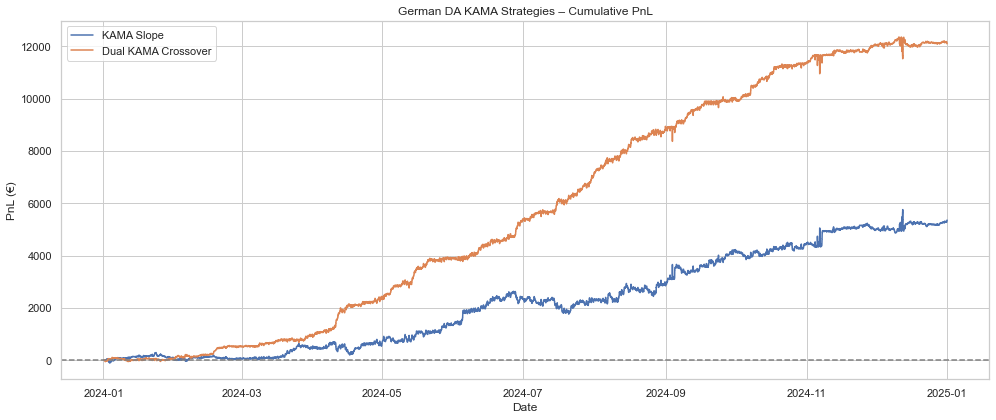

/Users/gaetanledu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,40,45,47,48,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



=== Optimizing DE CID (MWh euro) ===
Best KAMA Slope Strategy: window = 96, PnL = 5147.15 €, Hit Rate = 48.94%
Best Dual KAMA Strategy: fast = 576, slow = 1536, PnL = 12819.27 €, Hit Rate = 54.87%

=== Optimizing DE IP Price (MWh euro) ===
Best KAMA Slope Strategy: window = 1632, PnL = -47843.69 €, Hit Rate = 48.40%
Best Dual KAMA Strategy: fast = 480, slow = 768, PnL = 144324.74 €, Hit Rate = 38.93%


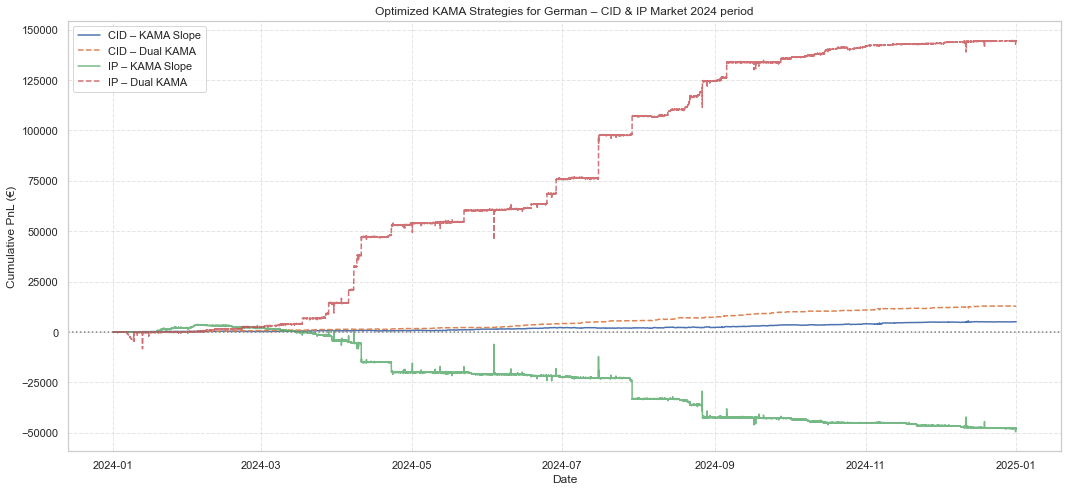

In [116]:
# ===========================================
# WHOLESALE MARKET POWER PRICES ANALYSIS
# ===========================================

print(" Power prices vol analysis using Kaufman’s Adaptive Moving Average (KAMA): ")
print(" KAMA is the best compare to other SMA, EMA or WMA in power prices due to high liquidity jump/fall")
print(" KAMA is great for trend-following or signal generation")
print(" DE IP market should be the one creating more profit due to his vol")

df = pd.read_csv(ALL_PATH)
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df.set_index('Start date', inplace=True)
price_col = 'DE (MWh euro)'
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
#price_cols = ['DE (MWh euro)', 'DE CID (MWh euro)', 'DE IP Price (MWh euro)']
#for col in price_cols: df[col] = pd.to_numeric(df[col], errors='coerce')

# ========== KAMA FUNCTION ==========
def compute_kama(series, window=96, fast=2, slow=30):
    series = series.copy()
    change = series.diff(window).abs()
    volatility = series.diff().abs().rolling(window).sum()
    er = change / volatility
    fast_sc = 2 / (fast + 1)
    slow_sc = 2 / (slow + 1)
    sc = (er * (fast_sc - slow_sc) + slow_sc) ** 2
    kama = series.copy()
    kama.iloc[:window] = series.iloc[:window]
    for i in range(window, len(series)):
        kama.iloc[i] = kama.iloc[i - 1] + sc.iloc[i] * (series.iloc[i] - kama.iloc[i - 1])
    return kama
# ========== STRATEGY 1: KAMA SLOPE ==========
df['KAMA'] = compute_kama(df[price_col], window=96)  # fixed 1-day window
df['slope_window'] = df['KAMA'].diff(96)  # 1-day slope
threshold = 0.0
# Include a threshold to reduce noise (adjustable)
df['signal_slope'] = np.where(df['slope_window'] > threshold, 1, np.where(df['slope_window'] < -threshold, -1, 0))

# ========== STRATEGY 2: DUAL KAMA CROSSOVER ==========
df['KAMA_fast'] = compute_kama(df[price_col], window=96)   # 1 day
df['KAMA_slow'] = compute_kama(df[price_col], window=960)  # 10 days
# Buy when fast < slow (reversed logic)
df['signal_dual'] = np.where(df['KAMA_fast'] < df['KAMA_slow'], 1, -1)

# ========== PNL FUNCTION ==========
def calculate_strategy(df, signal_col, label):
    df['position'] = df[signal_col].shift(1)
    df['return'] = df[price_col].diff()
    df['strategy_return'] = df['position'] * df['return']
    df[f'Cumulative PnL {label}'] = df['strategy_return'].cumsum()
    sharpe = df['strategy_return'].mean() / df['strategy_return'].std()
    hit_rate = (np.sign(df['strategy_return']) == np.sign(df['return'])).mean()
    final_pnl = df[f'Cumulative PnL {label}'].iloc[-1]
    print(f"--- {label} Strategy ---")
    print(f"Final PnL: {final_pnl:.2f} €")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Hit Rate: {hit_rate:.2%}")
    print()
    return df[f'Cumulative PnL {label}']

# ========== RUN ALL STRATEGIES ==========
pnl_slope = calculate_strategy(df.copy(), 'signal_slope', 'KAMA Slope')
pnl_dual = calculate_strategy(df.copy(), 'signal_dual', 'Dual KAMA')

# ========== PLOT ==========
plt.figure(figsize=(14, 6))
plt.plot(pnl_slope, label="KAMA Slope")
plt.plot(pnl_dual, label="Dual KAMA Crossover")
plt.axhline(0, linestyle='--', color='gray')
plt.title("German DA KAMA Strategies – Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("PnL (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== CONFIG ==========
price_cols = ['DE CID (MWh euro)', 'DE IP Price (MWh euro)']
window_range = range(96, 2881, 96)  # 1 to 30 days (96 intervals per day)
df = pd.read_csv(ALL_PATH)
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df.set_index('Start date', inplace=True)
for col in price_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ========== KAMA FUNCTION ==========
def compute_kama(series, window=96, fast=2, slow=30):
    series = series.copy()
    change = series.diff(window).abs()
    volatility = series.diff().abs().rolling(window).sum()
    er = change / volatility
    fast_sc = 2 / (fast + 1)
    slow_sc = 2 / (slow + 1)
    sc = (er * (fast_sc - slow_sc) + slow_sc) ** 2
    kama = series.copy()
    kama.iloc[:window] = series.iloc[:window]
    for i in range(window, len(series)):
        kama.iloc[i] = kama.iloc[i-1] + sc.iloc[i] * (series.iloc[i] - kama.iloc[i-1])
    return kama

# ========== STRATEGY CALCULATION ==========
def calculate_strategy(series, signal):
    returns = series.diff()
    position = signal.shift(1)
    strategy_return = position * returns
    cumulative_pnl = strategy_return.cumsum()
    hit_rate = (np.sign(strategy_return) == np.sign(returns)).mean()
    return cumulative_pnl, cumulative_pnl.iloc[-1], hit_rate

# ========== OPTIMIZER ==========
strategy_returns = {'CID': {}, 'IP': {}}
for market in price_cols:
    market_key = 'CID' if 'CID' in market else 'IP'
    series = df[market].dropna()
    best = {
        'slope': {'pnl': -np.inf, 'window': None, 'hit_rate': 0, 'returns': None},
        'dual': {'pnl': -np.inf, 'fast': None, 'slow': None, 'hit_rate': 0, 'returns': None}
    }

    print(f"\n=== Optimizing {market} ===")
    # Strategy 1: KAMA SLOPE
    for window in window_range:
        kama = compute_kama(series, window=window)
        slope = kama.diff(window)
        signal = np.where(slope > 0, 1, np.where(slope < 0, -1, 0))
        pnl_curve, pnl, hit = calculate_strategy(series, pd.Series(signal, index=series.index))
        if pnl > best['slope']['pnl']:
            best['slope'].update({'pnl': pnl, 'window': window, 'hit_rate': hit, 'returns': pnl_curve})
    # Strategy 2: DUAL KAMA
    for fast in window_range:
        for slow in window_range:
            if slow <= fast:
                continue
            kama_fast = compute_kama(series, window=fast)
            kama_slow = compute_kama(series, window=slow)
            signal = np.where(kama_fast < kama_slow, 1, -1)
            pnl_curve, pnl, hit = calculate_strategy(series, pd.Series(signal, index=series.index))
            if pnl > best['dual']['pnl']:
                best['dual'].update({'pnl': pnl, 'fast': fast, 'slow': slow, 'hit_rate': hit, 'returns': pnl_curve})
    # Display results
    print(f"Best KAMA Slope Strategy: window = {best['slope']['window']}, PnL = {best['slope']['pnl']:.2f} €, Hit Rate = {best['slope']['hit_rate']:.2%}")
    print(f"Best Dual KAMA Strategy: fast = {best['dual']['fast']}, slow = {best['dual']['slow']}, PnL = {best['dual']['pnl']:.2f} €, Hit Rate = {best['dual']['hit_rate']:.2%}")
    strategy_returns[market_key]['slope'] = best['slope']['returns']
    strategy_returns[market_key]['dual'] = best['dual']['returns']

# ========== PLOT ==========
plt.figure(figsize=(15, 7))
plt.plot(strategy_returns['CID']['slope'], label="CID – KAMA Slope", linestyle='-')
plt.plot(strategy_returns['CID']['dual'], label="CID – Dual KAMA", linestyle='--')
plt.plot(strategy_returns['IP']['slope'], label="IP – KAMA Slope", linestyle='-', alpha=0.8)
plt.plot(strategy_returns['IP']['dual'], label="IP – Dual KAMA", linestyle='--', alpha=0.8)
plt.axhline(0, linestyle=':', color='gray')
plt.title("Optimized KAMA Strategies for German – CID & IP Market 2024 period")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (€)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Epoch 1/50
902/902 [==============================] - 14s 9ms/step - loss: 6.2194e-04 - val_loss: 0.0010
Epoch 2/50
902/902 [==============================] - 7s 8ms/step - loss: 2.4615e-04 - val_loss: 0.0011
Epoch 3/50
902/902 [==============================] - 7s 8ms/step - loss: 1.8890e-04 - val_loss: 6.7504e-04
Epoch 4/50
902/902 [==============================] - 7s 8ms/step - loss: 1.6788e-04 - val_loss: 5.4979e-04
Epoch 5/50
902/902 [==============================] - 10s 11ms/step - loss: 1.6476e-04 - val_loss: 4.3085e-04
Epoch 6/50
902/902 [==============================] - 7s 8ms/step - loss: 1.5312e-04 - val_loss: 6.1555e-04
Epoch 7/50
902/902 [==============================] - 7s 8ms/step - loss: 1.5645e-04 - val_loss: 4.6384e-04
Epoch 8/50
902/902 [==============================] - 7s 8ms/step - loss: 1.5167e-04 - val_loss: 6.1341e-04
Epoch 9/50
902/902 [==============================] - 7s 7ms/step - loss: 1.4793e-04 - val_loss: 7.1585e-04
Epoch 10/50
93/93 [==============

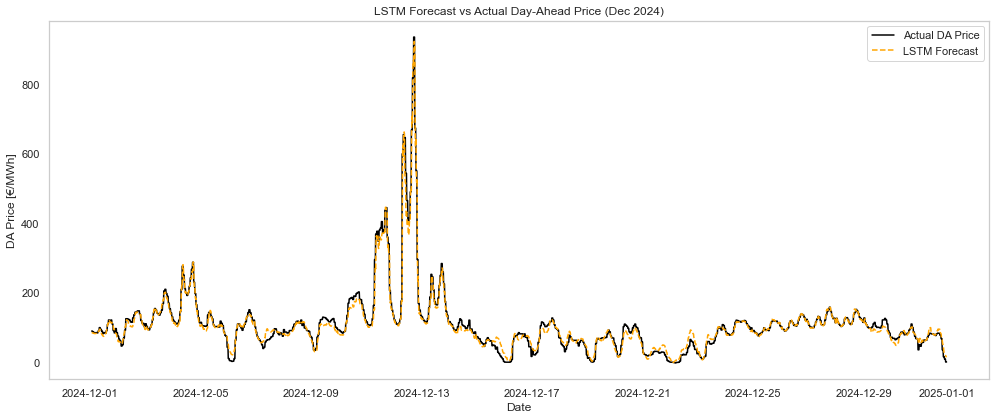

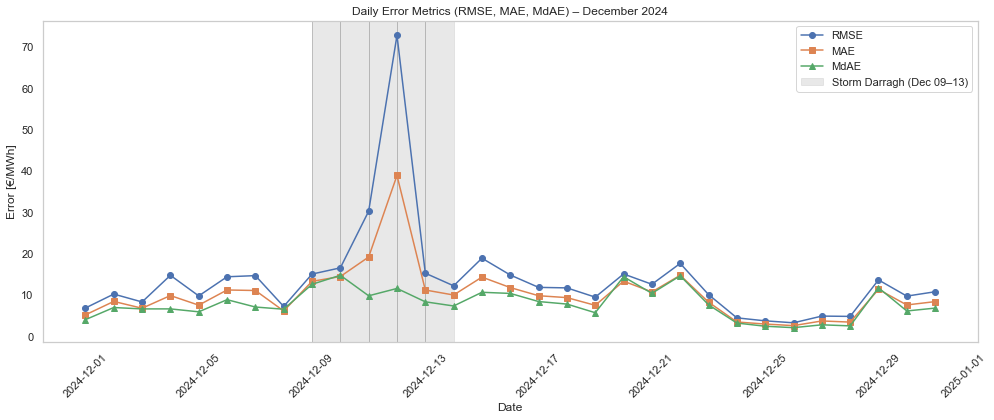


===== LSTM Forecast Evaluation (excluding Storm Darragh) =====
RMSE:  10.60 €/MWh
MAE:   8.43 €/MWh
MdAE:  7.21 €/MWh

 STRATEGY LOGIC SUMMARY

 1. Directional Forecasting Strategy

- Uses LSTM model to forecast day-ahead (DA) electricity prices in Germany.
- Computes the change in forecasted price at each 15-minute interval.
- If forecasted price is rising → take a long position (buy now, sell later).
- If forecasted price is falling → take a short position (sell now, buy back later).
- Position is based on the *sign* of the predicted change.
- PnL is calculated using the actual DA price movement following the signal.
- Assumes trading 1 MWh per interval with no transaction cost or filter.
- Goal: test raw directional skill of the forecast model.


 2. Optimized Trading Strategy with Volatility & Cost Filters

- Builds on the directional strategy but applies key improvements:
  • Volatility Filter: Only trade when price volatility (1-day rolling std) is low.
  • Threshold Filter: Onl

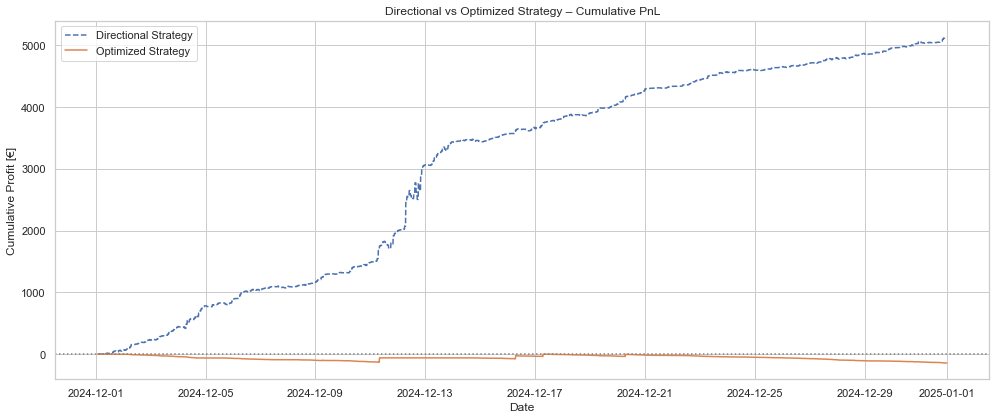

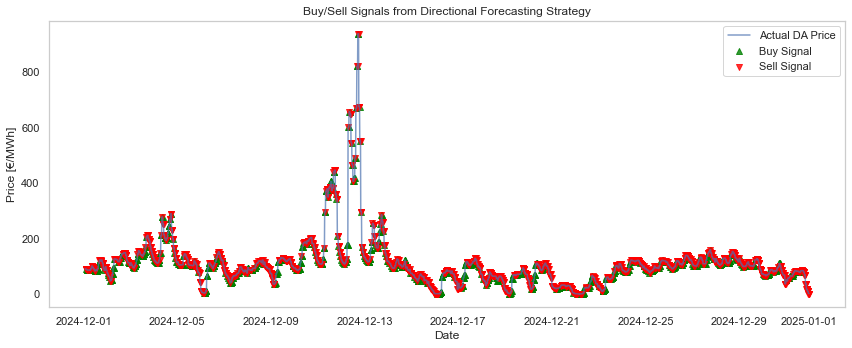

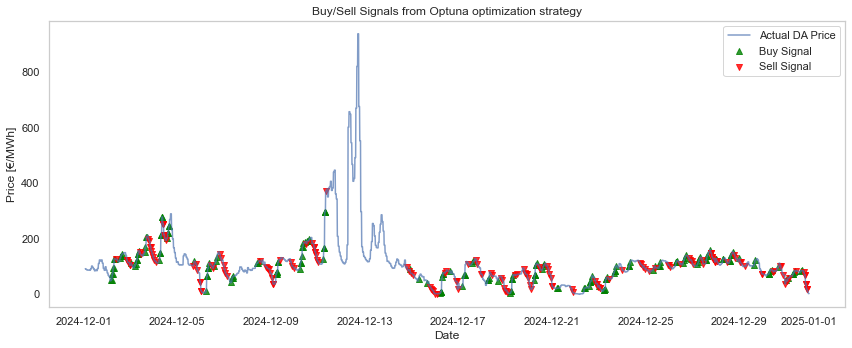


===== BEST PARAMETERS FOUND =====
Best Window Size: 93
Best Threshold: 3.94
Best Sharpe Ratio: 0.0443


In [45]:
# ===========================================
# LSTM FORECASTING
# ===========================================

df['DA Other [MWh] forecast'] = pd.to_numeric(df['DA Other [MWh] forecast'], errors='coerce')
target_col = 'DE (MWh euro)'
features = [
    'grid load [MWh] forecasted', 'Residual load [MWh] forecasted',
    'DA Photovoltaics and wind [MWh] forecast', 'DA Wind onshore [MWh] forecast',
    'DA Wind offshore [MWh] forecast', 'DA Photovoltaics [MWh] forecast',
    'DA Other [MWh] forecast', 'ID Photovoltaics and wind [MWh] forecast',
    'ID Wind onshore [MWh] forecast', 'ID Wind offshore [MWh] forecast',
    'ID Photovoltaics [MWh] forecast',
    'France [MWh - euro]', 'Netherlands [MWh - euro]', 'Belgium [MWh - euro]', 'Poland [MWh - euro]', 
    'Sweden [MWh - euro]', 'Denmark 1 [MWh - euro]', 'Denmark 2 [MWh - euro]', 'Switzerland [MWh - euro]',
    'Czech Republic [MWh - euro]', 'Austria [MWh - euro]'
]
df_model = df[['Start date', target_col] + features].dropna().sort_values('Start date')
train_df = df_model[df_model['Start date'] < '2024-12-01']
test_df = df_model[df_model['Start date'] >= '2024-12-01']

# ---------------------- Scaling ----------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_df[features])
test_X = scaler_X.transform(test_df[features])
train_y = scaler_y.fit_transform(train_df[[target_col]])
test_y = scaler_y.transform(test_df[[target_col]])
def reshape_for_lstm(X, y, window=6):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - window):
        X_lstm.append(X[i:i+window])
        y_lstm.append(y[i+window])
    return np.array(X_lstm), np.array(y_lstm)
window = 6
X_train_lstm, y_train_lstm = reshape_for_lstm(train_X, train_y, window)
X_test_lstm, y_test_lstm = reshape_for_lstm(test_X, test_y, window)
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ---------------------- Train Model ----------------------
model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
# ---------------------- Predictions ----------------------
preds_scaled = model.predict(X_test_lstm)
preds = scaler_y.inverse_transform(preds_scaled)
y_true = scaler_y.inverse_transform(y_test_lstm)

# ---------------------- Metrics ----------------------
rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
mdae = median_absolute_error(y_true, preds)
print("\n===== LSTM Forecast Evaluation =====")
print(f"RMSE:  {rmse:.2f} €/MWh")
print(f"MAE:   {mae:.2f} €/MWh")
print(f"MdAE:  {mdae:.2f} €/MWh")

# ---------------------- Create Forecast DataFrame ----------------------
forecast_dates = test_df['Start date'].iloc[window:].reset_index(drop=True)
forecast_df = pd.DataFrame({
    'Start date': forecast_dates,
    'Actual DA Price [euro/MWh]': y_true.flatten(),
    'Forecast DA Price [euro/MWh]': preds.flatten()
})
forecast_df.to_csv('/Users/gaetanledu/Documents/CASE/ENGIE/DE/LSTM_DA_forecast_vs_actual.csv', index=False)

# ---------------------- Plot Forecast vs Actual ----------------------
plt.figure(figsize=(14, 6))
plt.plot(forecast_df["Start date"], forecast_df["Actual DA Price [euro/MWh]"], label="Actual DA Price", color="black")
plt.plot(forecast_df["Start date"], forecast_df["Forecast DA Price [euro/MWh]"], label="LSTM Forecast", color="orange", linestyle="--")
plt.title("LSTM Forecast vs Actual Day-Ahead Price (Dec 2024)")
plt.xlabel("Date")
plt.ylabel("DA Price [€/MWh]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# ===========================================
# STORM IMPACT ON FORECASTING 
# ===========================================

# ---------------------- 1. Plot: RMSE, MAE, MdAE Evolution + Storm Highlight ----------------------
forecast_df["Date_only"] = forecast_df["Start date"].dt.date
daily_metrics = forecast_df.groupby("Date_only").apply(
    lambda x: pd.Series({
        "RMSE": np.sqrt(mean_squared_error(x["Actual DA Price [euro/MWh]"], x["Forecast DA Price [euro/MWh]"])),
        "MAE": mean_absolute_error(x["Actual DA Price [euro/MWh]"], x["Forecast DA Price [euro/MWh]"]),
        "MdAE": median_absolute_error(x["Actual DA Price [euro/MWh]"], x["Forecast DA Price [euro/MWh]"])
    })
).reset_index()

# Highlight Storm Darragh
storm_days = pd.date_range("2024-12-09", "2024-12-13").date
plt.figure(figsize=(14, 6))
plt.plot(daily_metrics["Date_only"], daily_metrics["RMSE"], label="RMSE", marker='o')
plt.plot(daily_metrics["Date_only"], daily_metrics["MAE"], label="MAE", marker='s')
plt.plot(daily_metrics["Date_only"], daily_metrics["MdAE"], label="MdAE", marker='^')
for day in storm_days:
    plt.axvspan(day, day, color='grey', alpha=0.8)
plt.axvspan(pd.to_datetime("2024-12-09"), pd.to_datetime("2024-12-14"), color='lightgrey', alpha=0.5, label="Storm Darragh (Dec 09–13)")
plt.title("Daily Error Metrics (RMSE, MAE, MdAE) – December 2024")
plt.xlabel("Date")
plt.ylabel("Error [€/MWh]")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ---------------------- 2. Print Mean Error Metrics (Excl. Storm) ----------------------
clean_metrics = daily_metrics[~daily_metrics["Date_only"].isin(storm_days)]

rmse_clean = clean_metrics["RMSE"].mean()
mae_clean = clean_metrics["MAE"].mean()
mdae_clean = clean_metrics["MdAE"].mean()

print("\n===== LSTM Forecast Evaluation (excluding Storm Darragh) =====")
print(f"RMSE:  {rmse_clean:.2f} €/MWh")
print(f"MAE:   {mae_clean:.2f} €/MWh")
print(f"MdAE:  {mdae_clean:.2f} €/MWh")


print("\n==============================")
print(" STRATEGY LOGIC SUMMARY")
print("==============================")

print("\n 1. Directional Forecasting Strategy")
print("""
- Uses LSTM model to forecast day-ahead (DA) electricity prices in Germany.
- Computes the change in forecasted price at each 15-minute interval.
- If forecasted price is rising → take a long position (buy now, sell later).
- If forecasted price is falling → take a short position (sell now, buy back later).
- Position is based on the *sign* of the predicted change.
- PnL is calculated using the actual DA price movement following the signal.
- Assumes trading 1 MWh per interval with no transaction cost or filter.
- Goal: test raw directional skill of the forecast model.
""")

print("\n 2. Optimized Trading Strategy with Volatility & Cost Filters")
print("""
- Builds on the directional strategy but applies key improvements:
  • Volatility Filter: Only trade when price volatility (1-day rolling std) is low.
  • Threshold Filter: Only act when predicted price change exceeds a threshold (1–5 €/MWh).
  • Transaction Cost: Accounts for market friction (1 €/MWh).
- Signals and thresholds are tuned using Optuna optimization.
- Trades are filtered for reliability and executed more conservatively.
- Sharpe Ratio (return/risk) is used as the optimization objective.
- Goal: build a more robust, realistic trading strategy.
""")
# ---------------------- Compute Changes ----------------------
forecast_df = pd.read_csv("/Users/gaetanledu/Documents/CASE/ENGIE/DE/LSTM_DA_forecast_vs_actual.csv")
forecast_df['Start date'] = pd.to_datetime(forecast_df['Start date'])
forecast_df["Forecast Change"] = forecast_df["Forecast DA Price [euro/MWh]"].diff()
forecast_df["Actual Change"] = forecast_df["Actual DA Price [euro/MWh]"].diff()
forecast_df["Direction Signal"] = forecast_df["Forecast Change"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
forecast_df["PnL_Directional"] = forecast_df["Direction Signal"].shift(1) * forecast_df["Actual Change"]
forecast_df["Cumulative_PnL_Directional"] = forecast_df["PnL_Directional"].cumsum()
total_trades = (forecast_df["Direction Signal"] != 0).sum()
buy_trades = (forecast_df["Direction Signal"] == 1).sum()
sell_trades = (forecast_df["Direction Signal"] == -1).sum()
final_pnl = forecast_df["Cumulative_PnL_Directional"].iloc[-1]

def objective(trial):
    window = trial.suggest_int("window", 24, 96)
    threshold = trial.suggest_float("threshold", 1.0, 5.0)
    transaction_cost = 1  # fixed for now
    forecast_df["Rolling Volatility"] = forecast_df["Actual DA Price [euro/MWh]"].rolling(window=best_window).std()
    forecast_df["Trade Filter"] = (forecast_df["Rolling Volatility"] < 50).astype(int)
    forecast_df["Filtered Direction Signal"] = forecast_df["Forecast Change"].apply(
        lambda x: 1 if x > best_threshold else (-1 if x < -best_threshold else 0)
    )
    forecast_df["Final Position"] = forecast_df["Filtered Direction Signal"] * forecast_df["Trade Filter"]
    forecast_df["PnL"] = forecast_df["Final Position"].shift(1) * forecast_df["Actual Change"] - \
                          np.abs(forecast_df["Final Position"].shift(1)) * transaction_cost
    forecast_df["Cumulative PnL"] = forecast_df["PnL"].cumsum()
    returns = forecast_df["PnL"].dropna()
    if len(returns) == 0 or np.std(returns) == 0:
        return -np.inf
    sharpe = np.mean(returns) / np.std(returns)
    return sharpe

# ---------------------- optuna details ----------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_window = study.best_params['window']
best_threshold = study.best_params['threshold']
transaction_cost = 1
forecast_df["Rolling Volatility"] = forecast_df["Actual DA Price [euro/MWh]"].rolling(window=best_window).std()
forecast_df["Trade Filter"] = (forecast_df["Rolling Volatility"] < 50).astype(int)
forecast_df["Filtered Direction Signal"] = forecast_df["Forecast Change"].apply(
    lambda x: 1 if x > best_threshold else (-1 if x < -best_threshold else 0))
forecast_df["Final Position"] = forecast_df["Filtered Direction Signal"] * forecast_df["Trade Filter"]
forecast_df["PnL"] = forecast_df["Final Position"].shift(1) * forecast_df["Actual Change"] - \
                      np.abs(forecast_df["Final Position"].shift(1)) * transaction_cost
forecast_df["Cumulative_PnL_Optimized"] = forecast_df["PnL"].cumsum()
opt_final_pnl = forecast_df["Cumulative_PnL_Optimized"].iloc[-1]
opt_total_trades = (forecast_df["Final Position"] != 0).sum()
opt_buy_trades = (forecast_df["Final Position"] > 0).sum()
opt_sell_trades = (forecast_df["Final Position"] < 0).sum()

# ---------------------- Perf Strats ----------------------
print(f"\n===== Directional Trading Strategy Summary =====")
print(f"Final Cumulative PnL: €{final_pnl:.2f}")
print(f"Total Trades: {total_trades}")
print(f"Buy Signals: {buy_trades}")
print(f"Sell Signals: {sell_trades}")
print(" ")
print(f"\n===== Optuna Optimized Trading Strategy Summary =====")
print(f"Final Cumulative PnL: €{opt_final_pnl:.2f}")
print(f"Total Trades: {opt_total_trades}")
print(f"Buy Signals: {opt_buy_trades}")
print(f"Sell Signals: {opt_sell_trades}")
print(" ")

# ---------------------- Best Result ----------------------
plt.figure(figsize=(14, 6))
plt.plot(forecast_df["Start date"], forecast_df["Cumulative_PnL_Directional"], label="Directional Strategy", linestyle="--")
plt.plot(forecast_df["Start date"], forecast_df["Cumulative_PnL_Optimized"], label="Optimized Strategy", linestyle="-")
plt.axhline(0, color='gray', linestyle=':')
plt.title("Directional vs Optimized Strategy – Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit [€]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------- Plot Buy/Sell Signals ----------------------
plt.figure(figsize=(12, 5))
plt.plot(forecast_df["Start date"], forecast_df["Actual DA Price [euro/MWh]"], label="Actual DA Price", alpha=0.7)
buy_signals = forecast_df[forecast_df["Direction Signal"] == 1]
sell_signals = forecast_df[forecast_df["Direction Signal"] == -1]
plt.scatter(buy_signals["Start date"], buy_signals["Actual DA Price [euro/MWh]"],
            color='green', marker='^', label='Buy Signal', alpha=0.8)
plt.scatter(sell_signals["Start date"], sell_signals["Actual DA Price [euro/MWh]"],
            color='red', marker='v', label='Sell Signal', alpha=0.8)
plt.title("Buy/Sell Signals from Directional Forecasting Strategy")
plt.xlabel("Date")
plt.ylabel("Price [€/MWh]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot Buy/Sell Signals
plt.figure(figsize=(12, 5))
plt.plot(forecast_df["Start date"], forecast_df["Actual DA Price [euro/MWh]"], label="Actual DA Price", alpha=0.7)
buy_signals = forecast_df[forecast_df["Final Position"] > 0]
sell_signals = forecast_df[forecast_df["Final Position"] < 0]
plt.scatter(buy_signals["Start date"], buy_signals["Actual DA Price [euro/MWh]"],
            color='green', marker='^', label='Buy Signal', alpha=0.8)
plt.scatter(sell_signals["Start date"], sell_signals["Actual DA Price [euro/MWh]"],
            color='red', marker='v', label='Sell Signal', alpha=0.8)
plt.title("Buy/Sell Signals from Optuna optimization strategy")
plt.xlabel("Date")
plt.ylabel("Price [€/MWh]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print("\n===== BEST PARAMETERS FOUND =====")
print(f"Best Window Size: {study.best_params['window']}")
print(f"Best Threshold: {study.best_params['threshold']:.2f}")
print(f"Best Sharpe Ratio: {study.best_value:.4f}")




[LightGBM] [Info] Number of positive: 7585, number of negative: 20143
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 27728, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273550 -> initscore=-0.976684
[LightGBM] [Info] Start training from score -0.976684

===== DA–CID Spread Prediction (LightGBM) =====

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      5037
           1       0.80      0.72      0.76      1896

    accuracy                           0.87      6933
   macro avg       0.85      0.83      0.84      6933
weighted avg       0.87      0.87      0.87      6933



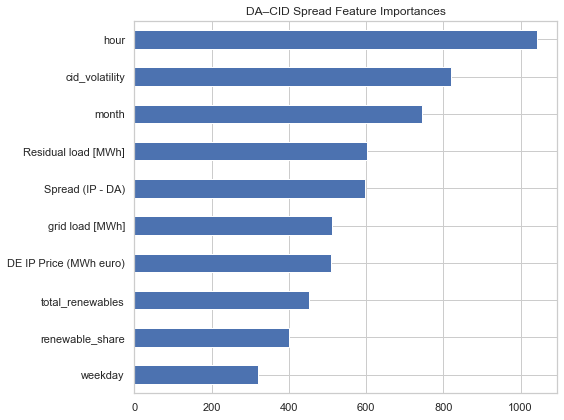

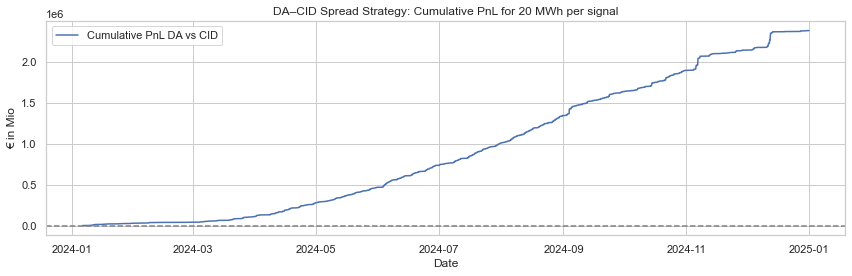

For a flow of 20MWh - The total cumulative PnL for this strategy for 2024 is €2,377,913.00


In [60]:
# ===========================================
# DA–CID SPREAD PREDICTION STRATEGY
# ===========================================

FLOW = 20  # MWh per trade
df["Start date"] = pd.to_datetime(df["Start date"], errors="coerce")
df["spread_DA_CID"] = df["DE (MWh euro)"] - df["DE CID (MWh euro)"]
df["Spread (IP - DA)"] = df["DE IP Price (MWh euro)"] - df["DE (MWh euro)"]
df["cid_volatility"] = df["DE CID (MWh euro)"].rolling(window=96).std()
df["DE IP Price (MWh euro)"] = df["DE IP Price (MWh euro)"]
df["target"] = (df["spread_DA_CID"] > 10).astype(int)
df["hour"] = df["Start date"].dt.hour
df["weekday"] = df["Start date"].dt.weekday
df["month"] = df["Start date"].dt.month
# Renewables related features
df["total_renewables"] = df[[
    "Wind onshore [MWh]", "Wind offshore [MWh]", "Photovoltaics [MWh]",
    "Biomass [MWh]", "Hydropower [MWh]", "Other renewable [MWh]"
]].sum(axis=1)
df["renewable_share"] = df["total_renewables"] / df["grid load [MWh]"]
df = df.dropna(subset=["cid_volatility", "target"])
features = [
    "hour", "weekday", "month", "Residual load [MWh]", "grid load [MWh]", "DE IP Price (MWh euro)",
    "total_renewables", "renewable_share", "cid_volatility", "Spread (IP - DA)"
]
df[features] = df[features].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=features)
X = df[features]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.columns = X_train.columns.str.replace(r"[^\w]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[^\w]", "_", regex=True)
model_cid = LGBMClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
model_cid.fit(X_train, y_train)
print("\n===== DA–CID Spread Prediction (LightGBM) =====\n")
print(classification_report(y_test, model_cid.predict(X_test)))
importances_cid = pd.Series(model_cid.feature_importances_, index=X.columns)
importances_cid.sort_values().plot(kind="barh", figsize=(8, 6), title="DA–CID Spread Feature Importances")
plt.tight_layout()
plt.show()
df["pred_prob_cid"] = model_cid.predict_proba(X)[:, 1]
df["signal_cid"] = (df["pred_prob_cid"] > 0.8).astype(int)
df["PnL_CID"] = df["signal_cid"].shift(1) * df["spread_DA_CID"] * FLOW
df["Cumulative PnL DA vs CID"] = df["PnL_CID"].cumsum()
plt.figure(figsize=(12, 4))
plt.plot(df["Start date"], df["Cumulative PnL DA vs CID"], label="Cumulative PnL DA vs CID")
plt.axhline(0, color="gray", linestyle="--")
plt.title(f"DA–CID Spread Strategy: Cumulative PnL for {FLOW} MWh per signal")
plt.ylabel("€ in Mio")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print(f"For a flow of 20MWh - The total cumulative PnL for this strategy for 2024 is €{df['Cumulative PnL DA vs CID'].iloc[-1]:,.2f}")


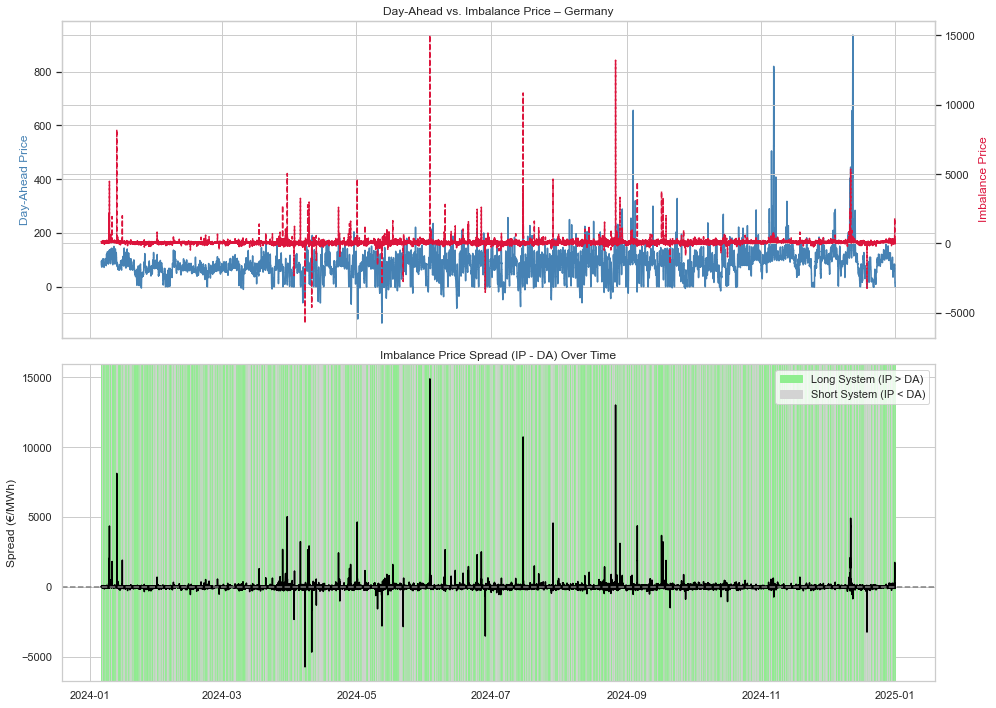

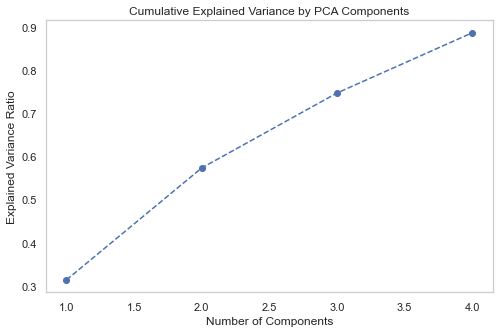

The first four principal components explain 88.63% of the variance.


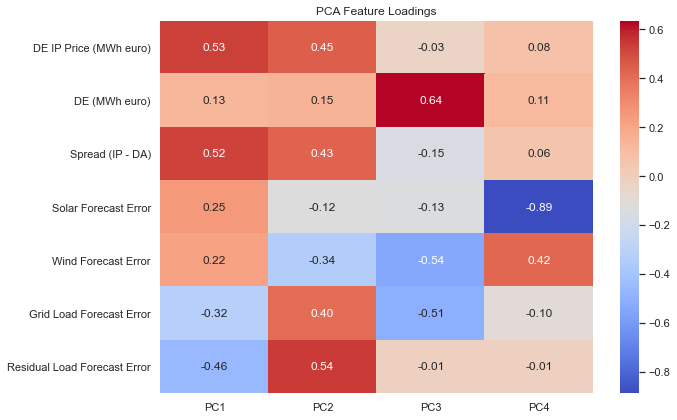

In [62]:
# ===========================================
# DAY-AHEAD VS IMBALANCE PRICE ANALYSIS
# ===========================================

# Feature engineering
df["Spread (IP - DA)"] = df["DE IP Price (MWh euro)"] - df["DE (MWh euro)"]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax1.plot(df["Start date"], df["DE (MWh euro)"], label="Day-Ahead Price", color="steelblue")
ax1b = ax1.twinx()
ax1b.plot(df["Start date"], df["DE IP Price (MWh euro)"], label="Imbalance Price", color="crimson", linestyle="dashed")
ax1.set_ylabel("Day-Ahead Price", color="steelblue")
ax1b.set_ylabel("Imbalance Price", color="crimson")
ax1.set_title("Day-Ahead vs. Imbalance Price – Germany")

# Bottom plot: Spread with color area
green_patch = mpatches.Patch(color='lightgreen', label='Long System (IP > DA)')
grey_patch = mpatches.Patch(color='lightgrey', label='Short System (IP < DA)')
ax2.legend(handles=[green_patch, grey_patch], loc='upper right')
ax2.plot(df["Start date"], df["Spread (IP - DA)"], color="black", label="Spread (IP - DA)")
for i in range(len(df) - 1):
    color = "lightgreen" if df["Spread (IP - DA)"].iloc[i] > 0 else "lightgrey"
    ax2.axvspan(df["Start date"].iloc[i], df["Start date"].iloc[i+1], color=color, alpha=0.3)
ax2.axhline(0, color="grey", linestyle="--")
ax2.set_ylabel("Spread (€/MWh)")
ax2.set_title("Imbalance Price Spread (IP - DA) Over Time")
plt.tight_layout()
plt.show()

# ===========================================
# PCA ANALYSIS ON IMBALANCE PRICE DATA
# ===========================================

df["Solar Forecast Error"] = df["DA Photovoltaics [MWh] forecast"] - df["Photovoltaics [MWh]"]
df["Wind Forecast Error"] = (
    df["DA Wind onshore [MWh] forecast"] + df["DA Wind offshore [MWh] forecast"]
) - (df["Wind onshore [MWh]"] + df["Wind offshore [MWh]"])
df["Grid Load Forecast Error"] = df["grid load [MWh] forecasted"] - df["grid load [MWh]"]
df["Residual Load Forecast Error"] = df["Residual load [MWh] forecasted"] - df["Residual load [MWh]"]
pca_features = [
    "DE IP Price (MWh euro)", "DE (MWh euro)", "Spread (IP - DA)",
    "Solar Forecast Error", "Wind Forecast Error",
    "Grid Load Forecast Error", "Residual Load Forecast Error"
]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[pca_features].dropna())
pca = PCA(n_components=4)
pca_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(pca_components, columns=["PC1", "PC2", "PC3", "PC4"])
df_pca["Start date"] = df["Start date"].iloc[-len(df_pca):].values
plt.figure(figsize=(8, 5))
plt.plot(range(1, 5), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.show()

print(f"The first four principal components explain {np.sum(pca.explained_variance_ratio_):.2%} of the variance.")

# PCA Loadings (Feature Importance)
loadings = pd.DataFrame(pca.components_.T, index=pca_features, columns=["PC1", "PC2", "PC3", "PC4"])
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PCA Feature Loadings")
plt.tight_layout()
plt.show()



KMeans vs GMM Clustering Logic:
- KMeans assigns each point hard to one cluster center (distance-based)
- GMM assigns probabilities assuming Gaussian distributions (soft clustering)


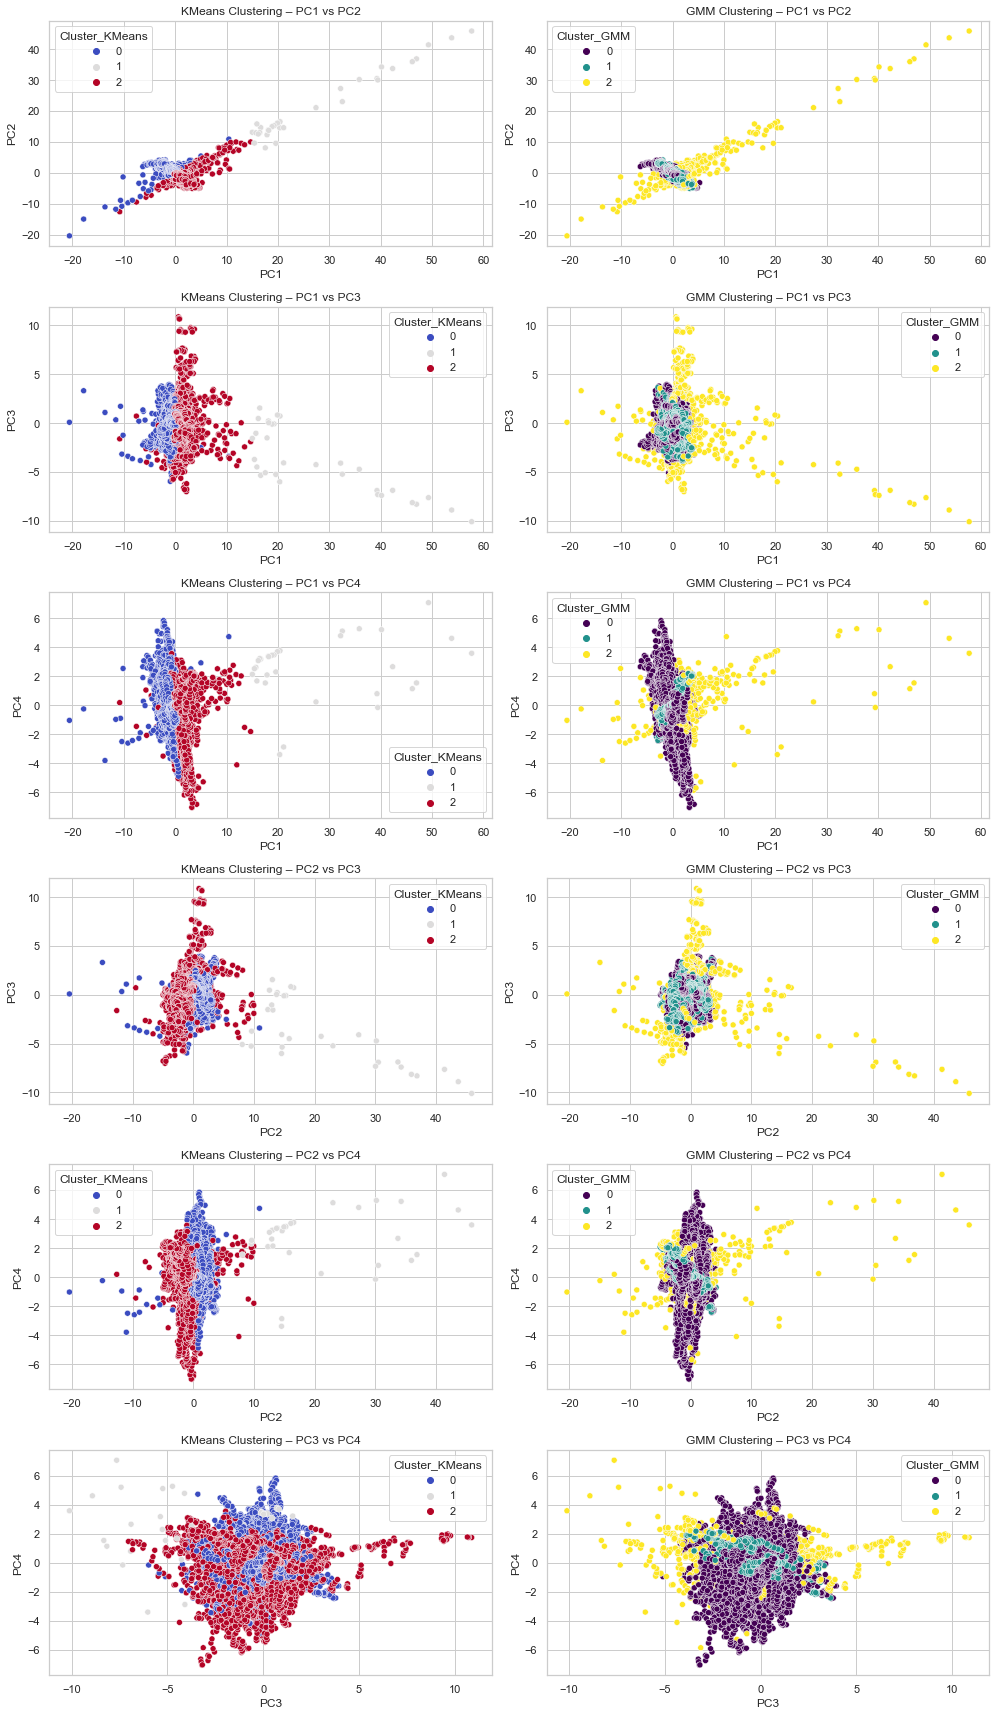


GMM Profitable Cluster Detected: 2

KMeans Low Vol Cluster Detected: 0
KMeans High Vol Cluster Detected: 1


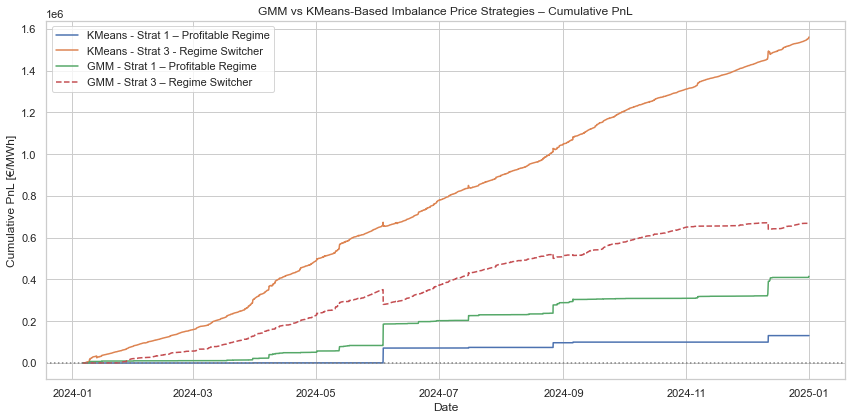


===== Strategy Performance Summary =====

GMM Strategy 1 – Profitable Regime Only:
Total PnL: €414,485.42, Trades: 758, Win Rate: 61.6%, Sharpe Ratio: 0.05
GMM Strategy 3 – Regime Switcher:
Total PnL: €668,633.28, Trades: 18701, Win Rate: 71.4%, Sharpe Ratio: 0.09

KMeans Strategy 1 – Profitable Regime Only:
Total PnL: €131,077.06, Trades: 30, Win Rate: 56.7%, Sharpe Ratio: 0.02
KMeans Strategy 3 – Regime Switcher:
Total PnL: €1,560,242.11, Trades: 34542, Win Rate: 74.5%, Sharpe Ratio: 0.21

===== Strategy logic =====

Strategy 1: aims to trade only when the market is in a profitable regime (When Imbalance price is higher than CID), where the price spread between the Imbalance Price (IP) and Day-Ahead (DA) is favorable.
If the market is in the profitable KMeans/GMM cluster and the price spread (Spread (IP - DA)) is positive, a buy signal (1) is generated.
If the price spread is negative, a sell signal (-1) is generated.
Otherwise, no trade is executed (0).

Strategy 3: This strategy u

In [63]:
# ===========================================
# CLUSTERING WITH KMEANS AND GMM
# ===========================================

print("\nKMeans vs GMM Clustering Logic:")
print("- KMeans assigns each point hard to one cluster center (distance-based)")
print("- GMM assigns probabilities assuming Gaussian distributions (soft clustering)")

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_pca["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)
gmm = GaussianMixture(n_components=3, random_state=42)
df_pca["Cluster_GMM"] = gmm.fit_predict(X_scaled)
combinations = list(itertools.combinations(["PC1", "PC2", "PC3", "PC4"], 2))
fig, axes = plt.subplots(len(combinations), 2, figsize=(14, len(combinations) * 4))
for i, (pc_x, pc_y) in enumerate(combinations):
    sns.scatterplot(data=df_pca, x=pc_x, y=pc_y, hue="Cluster_KMeans", palette="coolwarm", ax=axes[i, 0])
    axes[i, 0].set_title(f"KMeans Clustering – {pc_x} vs {pc_y}")
    sns.scatterplot(data=df_pca, x=pc_x, y=pc_y, hue="Cluster_GMM", palette="viridis", ax=axes[i, 1])
    axes[i, 1].set_title(f"GMM Clustering – {pc_x} vs {pc_y}")
plt.tight_layout()
plt.show()

# ===========================================
# TRADING STRATEGIES BASED ON REGIME SWITCHING
# ===========================================

final_df = df.merge(df_pca[['Start date', 'Cluster_KMeans', 'Cluster_GMM']], on='Start date', how='left')
final_df['Spread (IP - DA)'] = final_df['DE IP Price (MWh euro)'] - final_df['DE (MWh euro)']

# ===================== GMM Clustering Analysis =====================

gmm_cluster_mean_spreads = final_df.groupby('Cluster_GMM')['Spread (IP - DA)'].mean()
profitable_gmm_cluster = gmm_cluster_mean_spreads.idxmax()
print(f"\nGMM Profitable Cluster Detected: {profitable_gmm_cluster}")
# Strategy 1: Trade in Profitable Regime Only
final_df['Signal_ProfitOnly'] = final_df.apply(
    lambda row: 1 if row['Cluster_GMM'] == profitable_gmm_cluster and row['Spread (IP - DA)'] > 0 else
                -1 if row['Cluster_GMM'] == profitable_gmm_cluster and row['Spread (IP - DA)'] < 0 else 0,axis=1)
final_df['PnL_ProfitOnly'] = final_df['Signal_ProfitOnly'].shift(1) * final_df['Spread (IP - DA)']
final_df['Cumulative PnL ProfitOnly'] = final_df['PnL_ProfitOnly'].cumsum()
# Strategy 3: Volatility Regime Switcher (based on KMeans)
# Detect low vol and high vol clusters dynamically
kmeans_volatility = final_df.groupby('Cluster_KMeans')['Spread (IP - DA)'].std()
low_vol_cluster = kmeans_volatility.idxmin()
high_vol_cluster = kmeans_volatility.idxmax()
print(f"\nKMeans Low Vol Cluster Detected: {low_vol_cluster}")
print(f"KMeans High Vol Cluster Detected: {high_vol_cluster}")
def regime_strategy(row):
    if row['Cluster_KMeans'] == low_vol_cluster:
        return 1 if row['Spread (IP - DA)'] > 0 else -1
    elif row['Cluster_KMeans'] == high_vol_cluster:
        return -1 if row['Spread (IP - DA)'] > 0 else 1
    else:
        return 0
final_df['Signal_RegimeSwitch'] = final_df.apply(regime_strategy, axis=1)
final_df['PnL_RegimeSwitch'] = final_df['Signal_RegimeSwitch'].shift(1) * final_df['Spread (IP - DA)']
final_df['Cumulative PnL RegimeSwitch'] = final_df['PnL_RegimeSwitch'].cumsum()

# ===================== KMeans Clustering Analysis =====================

df["Spread (IP - DA)"] = df["DE IP Price (MWh euro)"] - df["DE (MWh euro)"]
df["Volatility"] = df["Spread (IP - DA)"].rolling(window=96).std()
features = ["Spread (IP - DA)", "Volatility"]
df_cluster = df.dropna(subset=features).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)
df = df.merge(df_cluster[["Start date", "Cluster_KMeans"]], on="Start date", how="left")
# Find profitable cluster dynamically (KMeans)
kmeans_cluster_mean_spreads = df.groupby('Cluster_KMeans')["Spread (IP - DA)"].mean()
profitable_kmeans_cluster = kmeans_cluster_mean_spreads.idxmax()
# Strategy 1 – Profitable Cluster (KMeans)
df["Signal_KMeans_Strat1"] = df.apply(
    lambda row: np.sign(row["Spread (IP - DA)"]) if row["Cluster_KMeans"] == profitable_kmeans_cluster else 0, axis=1)
df["PnL_KMeans_Strat1"] = df["Signal_KMeans_Strat1"].shift(1) * df["Spread (IP - DA)"]
df["Cumulative_PnL_KMeans_Strat1"] = df["PnL_KMeans_Strat1"].cumsum()
# Strategy 3 – Regime Switcher (KMeans)
low_vol_cluster_kmeans = df.groupby("Cluster_KMeans")["Volatility"].mean().idxmin()
high_vol_cluster_kmeans = df.groupby("Cluster_KMeans")["Volatility"].mean().idxmax()
def strat3_kmeans(row):
    if row["Cluster_KMeans"] == low_vol_cluster_kmeans:
        return np.sign(row["Spread (IP - DA)"])  # momentum
    elif row["Cluster_KMeans"] == high_vol_cluster_kmeans:
        return -np.sign(row["Spread (IP - DA)"])  # mean-reversion
    else:
        return 0
df["Signal_KMeans_Strat3"] = df.apply(strat3_kmeans, axis=1)
df["PnL_KMeans_Strat3"] = df["Signal_KMeans_Strat3"].shift(1) * df["Spread (IP - DA)"]
df["Cumulative_PnL_KMeans_Strat3"] = df["PnL_KMeans_Strat3"].cumsum()
# ===================== Metrics =====================
def evaluate_strategy(signal_col, pnl_col, dataset):
    trades = dataset[signal_col] != 0
    n_trades = trades.sum()
    win_rate = (dataset.loc[trades, pnl_col] > 0).mean()
    sharpe = dataset[pnl_col].mean() / dataset[pnl_col].std()
    total_pnl = dataset[pnl_col].sum()
    return total_pnl, n_trades, win_rate, sharpe
metrics_gmm_1 = evaluate_strategy('Signal_ProfitOnly', 'PnL_ProfitOnly', final_df)
metrics_gmm_3 = evaluate_strategy('Signal_RegimeSwitch', 'PnL_RegimeSwitch', final_df)
metrics_kmeans_1 = evaluate_strategy('Signal_KMeans_Strat1', 'PnL_KMeans_Strat1', df)
metrics_kmeans_3 = evaluate_strategy('Signal_KMeans_Strat3', 'PnL_KMeans_Strat3', df)
# ===================== PnL Plots =====================
plt.figure(figsize=(12, 6))
plt.plot(df["Start date"], df["Cumulative_PnL_KMeans_Strat1"], label='KMeans - Strat 1 – Profitable Regime')
plt.plot(df["Start date"], df["Cumulative_PnL_KMeans_Strat3"], label='KMeans - Strat 3 - Regime Switcher')
plt.plot(final_df['Start date'], final_df['Cumulative PnL ProfitOnly'], label='GMM - Strat 1 – Profitable Regime')
plt.plot(final_df['Start date'], final_df['Cumulative PnL RegimeSwitch'], label='GMM - Strat 3 – Regime Switcher', linestyle='--')
plt.axhline(0, linestyle=':', color='gray')
plt.title("GMM vs KMeans-Based Imbalance Price Strategies – Cumulative PnL")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL [€/MWh]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ===================== Performance Printout =====================
print("\n===== Strategy Performance Summary =====\n")
print(f"GMM Strategy 1 – Profitable Regime Only:\nTotal PnL: €{metrics_gmm_1[0]:,.2f}, Trades: {metrics_gmm_1[1]}, Win Rate: {metrics_gmm_1[2]*100:.1f}%, Sharpe Ratio: {metrics_gmm_1[3]:.2f}")
print(f"GMM Strategy 3 – Regime Switcher:\nTotal PnL: €{metrics_gmm_3[0]:,.2f}, Trades: {metrics_gmm_3[1]}, Win Rate: {metrics_gmm_3[2]*100:.1f}%, Sharpe Ratio: {metrics_gmm_3[3]:.2f}\n")
print(f"KMeans Strategy 1 – Profitable Regime Only:\nTotal PnL: €{metrics_kmeans_1[0]:,.2f}, Trades: {metrics_kmeans_1[1]}, Win Rate: {metrics_kmeans_1[2]*100:.1f}%, Sharpe Ratio: {metrics_kmeans_1[3]:.2f}")
print(f"KMeans Strategy 3 – Regime Switcher:\nTotal PnL: €{metrics_kmeans_3[0]:,.2f}, Trades: {metrics_kmeans_3[1]}, Win Rate: {metrics_kmeans_3[2]*100:.1f}%, Sharpe Ratio: {metrics_kmeans_3[3]:.2f}")

print("\n===== Strategy logic =====\n")
print("Strategy 1: aims to trade only when the market is in a profitable regime (When Imbalance price is higher than CID), where the price spread between the Imbalance Price (IP) and Day-Ahead (DA) is favorable.")
print("If the market is in the profitable KMeans/GMM cluster and the price spread (Spread (IP - DA)) is positive, a buy signal (1) is generated.")
print("If the price spread is negative, a sell signal (-1) is generated.")
print("Otherwise, no trade is executed (0).")
print("")
print("Strategy 3: This strategy uses market regime switching to dynamically change the trading approach based on the market conditions, specifically targeting high and low volatility regimes.")
print("In the low volatility cluster, the strategy follows a momentum approach, generating a buy signal (1) when the price spread is positive, or a sell signal (-1) when the price spread is negative.")
print("In the high volatility cluster, the strategy follows a mean-reversion approach, generating a sell signal (-1) when the price spread is positive, or a buy signal (1) when the price spread is negative.")
print("If the market is in any other cluster, no trade is executed (0).")


========= Battery Optimizer - Model Features & Assumptions =========
1. Simulation Period: Full year 2024 (Jan 1 - Dec 31)
2. Battery Parameters:
   - Capacity: 100 MWh
   - Max Power: 50 MW (charge/discharge)
   - Charging Efficiency: 95.0%
   - Discharging Efficiency: 95.0%
3. Trading Constraints:
   - Max Cycles per Day: 2 full cycles
   - Max Storage Hold Time: 120 minutes (2 hours)
   - Profit Spread Threshold: 5 €/MWh minimum to trigger trade
   - Trading Fee: 0.75 €/MWh (buy and sell)
4. Optimization Strategy:
   - Dynamic Early Exits: Battery discharges early if near-future price is almost as good as best future.
   - No Imbalance Costs: Assumes perfect execution on DA auction volumes.
   - No Partial Fills: Assume 50MW charge/discharge possible every 15 minutes without liquidity issues.
5. Degradation Costs:
   - Cycling OPEX: 5€/MWh charged (battery aging and maintenance impact)
6. Risk Management:
   - Minimized Forced Discharges: Early exits before storage expiration (2h) 

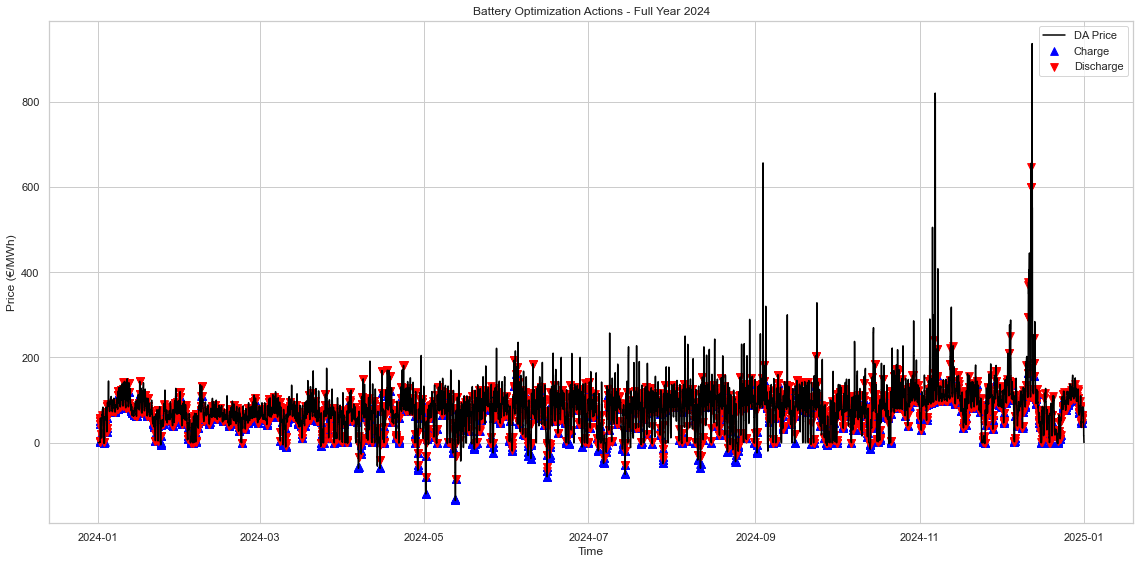

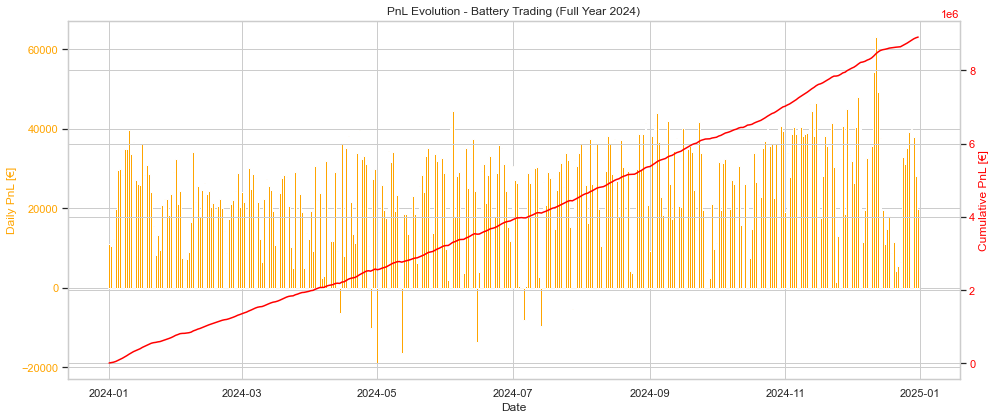


========= Final Summary =========
Total cumulative PnL: €8,905,120.15
Average Daily PnL: €24,330.93
Forced Discharge Total: 2742.53 MWh
Normal Discharge Total: 0.00 MWh
Early Discharge Total: 63004.24 MWh
Normal discharges = planned perfect spreads. Early discharges = smart risk-managed exits. Forced discharges = emergency dumps.


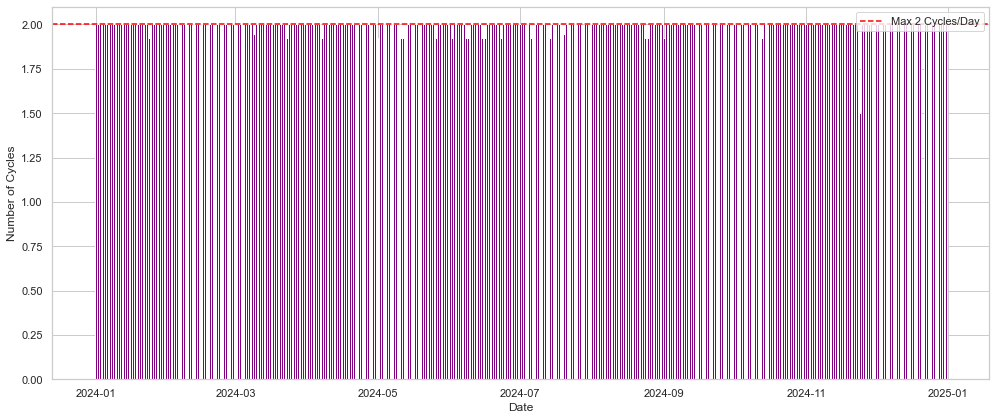

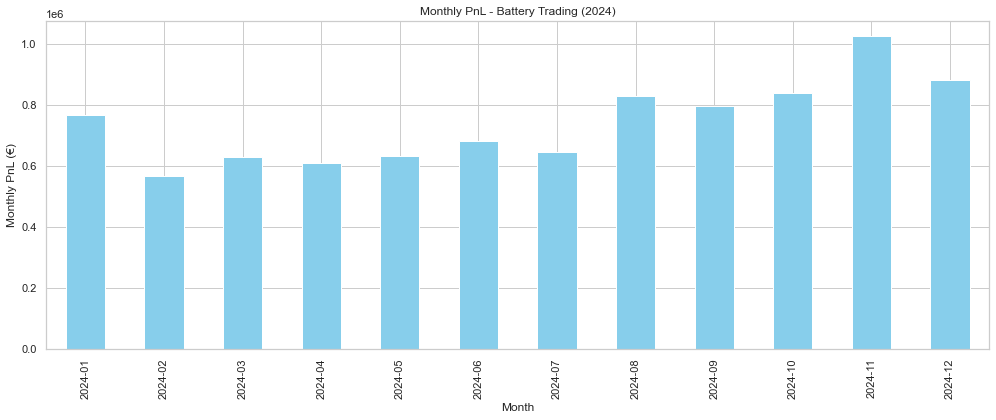


========= Realized Spread Summary =========
Average Buy Price: 60.36 €/MWh
Average Sell Price: 73.20 €/MWh
Realized Spread: 12.85 €/MWh

========= Degradation Cost Impact =========
Total Degradation Cost: €346,035.68 -- assume €5 per MWh cycled for OPEX / degradation.
Net PnL after Degradation: €8,559,084.47


In [137]:
# ===========================================
# SMART BATTERY OPTIMIZER SETUP (BESS)
# ===========================================

if not pd.api.types.is_datetime64_any_dtype(df['Start date']):
    df['Start date'] = pd.to_datetime(df['Start date'])
df_year = df[(df['Start date'] >= '2024-01-01') & (df['Start date'] < '2025-01-01')].copy()
df_year['Quarter'] = df_year['Start date'].dt.hour * 4 + (df_year['Start date'].dt.minute // 15)
df_year['Date'] = df_year['Start date'].dt.date
da_curves = df_year.groupby('Date').apply(lambda x: x.set_index('Quarter')['DE (MWh euro)'].to_dict())

# --- 2. Battery and Trading Parameters ---
params = {
    'battery_capacity_mwh': 100,               # Total energy capacity
    'battery_power_mw': 50,                    # Max charge/discharge power
    'charging_efficiency': 0.95,               # Charging efficiency
    'discharging_efficiency': 0.95,             # Discharging efficiency
    'time_step_hours': 0.25,                   # 15 minutes
    'max_storage_duration_qh': 8,              # 2 hours max storage
    'profit_spread_threshold': 5,              # Minimum spread to enter trades
    'max_cycles_per_day': 2,                   # Max 2 full cycles per day
    'trading_fee_eur_per_mwh': 0.75             # Trading fee per MWh traded
}

# --- 3. Simulation Engine ---
results = []
charge_actions = []
discharge_actions = []
storage_units = []  # Each unit: {energy, age_qh}
storage_level = 0
sorted_dates = sorted(da_curves.index)
for today_date in sorted_dates:
    da_prices = da_curves[today_date]
    pnl_today = 0
    charged_today = 0.0
    discharged_today = 0.0
    for q in range(96):
        price_now = da_prices.get(q, np.nan)
        if np.isnan(price_now):
            continue
        today_datetime = datetime.combine(today_date, time(hour=q//4, minute=(q%4)*15))
        # Update unit aging
        for unit in storage_units:
            unit['age_qh'] += 1
        # Early exit logic: discharge if price_now is good enough
        if storage_level > 0:
            future_prices = [da_prices.get(qq, np.nan) for qq in range(q+1, q+2)]
            future_prices = [p for p in future_prices if not np.isnan(p)]
            if future_prices:
                next_15min_price = future_prices[0]
                # Early discharge condition
                if price_now >= 0.90 * next_15min_price:
                    available_energy = storage_level
                    discharge_energy = min(available_energy, params['battery_power_mw'] * params['time_step_hours'])
                    effective_energy = discharge_energy * params['discharging_efficiency']
                    pnl_today += effective_energy * (price_now - params['trading_fee_eur_per_mwh'])
                    storage_level -= discharge_energy
                    discharged_today += discharge_energy
                    discharge_actions.append((today_datetime, effective_energy, price_now, 'early'))
                    for unit in storage_units:
                        take = min(discharge_energy, unit['energy'])
                        unit['energy'] -= take
                        discharge_energy -= take
                        if discharge_energy <= 0:
                            break
                    storage_units = [u for u in storage_units if u['energy'] > 0]
        # Forced discharge if storage exceeds max hold duration
        forced_units = [u for u in storage_units if u['age_qh'] > params['max_storage_duration_qh']]
        for unit in forced_units:
            discharge_energy = unit['energy']
            effective_energy = discharge_energy * params['discharging_efficiency']
            pnl_today += effective_energy * (price_now - params['trading_fee_eur_per_mwh'])
            discharge_actions.append((today_datetime, effective_energy, price_now, 'forced'))
            storage_level -= discharge_energy
            discharged_today += discharge_energy
            unit['energy'] = 0
        storage_units = [u for u in storage_units if u['energy'] > 0]
        # Entry decision: Charging
        future_prices = [da_prices.get(qq, np.nan) for qq in range(q+1, min(q+params['max_storage_duration_qh']+1, 96))]
        future_prices = [p for p in future_prices if not np.isnan(p)]
        if not future_prices:
            continue
        best_future_price = max(future_prices)
        worst_future_price = min(future_prices)
        max_energy_step = params['battery_power_mw'] * params['time_step_hours']
        if (best_future_price - price_now) >= params['profit_spread_threshold'] and storage_level < params['battery_capacity_mwh']:
            available_storage = params['battery_capacity_mwh'] - storage_level
            charge_energy = min(available_storage, max_energy_step)
            effective_energy = charge_energy * params['charging_efficiency']
            if (charged_today + charge_energy) / params['battery_capacity_mwh'] <= params['max_cycles_per_day']:
                pnl_today -= charge_energy * (price_now + params['trading_fee_eur_per_mwh'])
                storage_units.append({'energy': effective_energy, 'age_qh': 0})
                storage_level += effective_energy
                charged_today += charge_energy
                charge_actions.append((today_datetime, effective_energy, price_now, 'normal'))
    results.append({
        'Date': today_date,
        'Daily PnL (€)': pnl_today,
        'End Storage Level (MWh)': storage_level,
        'Daily Charged (MWh)': charged_today,
        'Daily Discharged (MWh)': discharged_today
    })

# BESS details (Features and Assumptions): 
print("\n========= Battery Optimizer - Model Features & Assumptions =========")
print("1. Simulation Period: Full year 2024 (Jan 1 - Dec 31)")
print("2. Battery Parameters:")
print(f"   - Capacity: {params['battery_capacity_mwh']} MWh")
print(f"   - Max Power: {params['battery_power_mw']} MW (charge/discharge)")
print(f"   - Charging Efficiency: {params['charging_efficiency']*100:.1f}%")
print(f"   - Discharging Efficiency: {params['discharging_efficiency']*100:.1f}%")
print("3. Trading Constraints:")
print(f"   - Max Cycles per Day: {params['max_cycles_per_day']} full cycles")
print(f"   - Max Storage Hold Time: {params['max_storage_duration_qh']*15} minutes (2 hours)")
print(f"   - Profit Spread Threshold: {params['profit_spread_threshold']} €/MWh minimum to trigger trade")
print(f"   - Trading Fee: {params['trading_fee_eur_per_mwh']} €/MWh (buy and sell)")
print("4. Optimization Strategy:")
print("   - Dynamic Early Exits: Battery discharges early if near-future price is almost as good as best future.")
print("   - No Imbalance Costs: Assumes perfect execution on DA auction volumes.")
print("   - No Partial Fills: Assume 50MW charge/discharge possible every 15 minutes without liquidity issues.")
print("5. Degradation Costs:")
print("   - Cycling OPEX: 5€/MWh charged (battery aging and maintenance impact)")
print("6. Risk Management:")
print("   - Minimized Forced Discharges: Early exits before storage expiration (2h) to lock profits.")
print("=====================================================================")

price_plot_df = df_year.copy()
charge_df = pd.DataFrame(charge_actions, columns=['Timestamp', 'Energy (MWh)', 'Price', 'Type'])
discharge_df = pd.DataFrame(discharge_actions, columns=['Timestamp', 'Energy (MWh)', 'Price', 'Type'])
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(price_plot_df['Start date'], price_plot_df['DE (MWh euro)'], color='black', label='DA Price')
ax.scatter(charge_df['Timestamp'], charge_df['Price'], marker='^', color='blue', label='Charge', s=60)
ax.scatter(discharge_df['Timestamp'], discharge_df['Price'], marker='v', color='red', label='Discharge', s=60)
ax.set_xlabel('Time')
ax.set_ylabel('Price (€/MWh)')
ax.legend()
plt.title('Battery Optimization Actions - Full Year 2024')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 5. PnL Evolution and Daily Cycles ---

results_df = pd.DataFrame(results)
all_trades = pd.concat([charge_df, discharge_df]).sort_values('Timestamp')
all_trades['PnL (€)'] = np.where(all_trades['Type'] == 'normal',
                                  all_trades['Energy (MWh)'] * all_trades['Price'],
                                  all_trades['Energy (MWh)'] * all_trades['Price'])
all_trades['Date'] = all_trades['Timestamp'].dt.date
daily_pnl = all_trades.groupby('Date')['PnL (€)'].sum()
cumulative_pnl = daily_pnl.cumsum()
# PnL evolution plot
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.bar(daily_pnl.index, daily_pnl.values, label='Daily PnL (€)', color='orange')
ax1.set_ylabel('Daily PnL [€]', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
ax2.plot(cumulative_pnl.index, cumulative_pnl.values, label='Cumulative PnL (€)', color='red')
ax2.set_ylabel('Cumulative PnL [€]', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('PnL Evolution - Battery Trading (Full Year 2024)')
fig.tight_layout()
plt.grid(True)
plt.show()

# --- 6. Final Summary ---

forced_total = discharge_df[discharge_df['Type'] == 'forced']['Energy (MWh)'].sum()
normal_total = discharge_df[discharge_df['Type'] == 'normal']['Energy (MWh)'].sum()
early_total = discharge_df[discharge_df['Type'] == 'early']['Energy (MWh)'].sum()
print("\n========= Final Summary =========")
print(f"Total cumulative PnL: €{cumulative_pnl.iloc[-1]:,.2f}")
print(f"Average Daily PnL: €{daily_pnl.mean():,.2f}")
print(f"Forced Discharge Total: {forced_total:.2f} MWh")
print(f"Normal Discharge Total: {normal_total:.2f} MWh")
print(f"Early Discharge Total: {early_total:.2f} MWh")
print("Normal discharges = planned perfect spreads. Early discharges = smart risk-managed exits. Forced discharges = emergency dumps.")
print("===================================")

# --- 7. Plot Daily Cycles ---
results_df['Daily Cycles'] = results_df['Daily Charged (MWh)'] / params['battery_capacity_mwh']
plt.figure(figsize=(14,6))
plt.bar(results_df['Date'], results_df['Daily Cycles'], color='purple')
plt.axhline(params['max_cycles_per_day'], color='red', linestyle='--', label=f"Max {params['max_cycles_per_day']} Cycles/Day")
plt.xlabel('Date')
plt.ylabel('Number of Cycles')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 8. Monthly PnL Breakdown ---

# Calculate monthly PnL
all_trades['Month'] = all_trades['Timestamp'].dt.to_period('M')
monthly_pnl = all_trades.groupby('Month')['PnL (€)'].sum()
fig, ax = plt.subplots(figsize=(14,6))
monthly_pnl.plot(kind='bar', color='skyblue')
plt.title('Monthly PnL - Battery Trading (2024)')
plt.xlabel('Month')
plt.ylabel('Monthly PnL (€)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 9. Realized Spread per MWh ---

# Total traded energy
total_charged_energy = charge_df['Energy (MWh)'].sum()
total_discharged_energy = discharge_df['Energy (MWh)'].sum()
# Average buy and sell prices
avg_buy_price = charge_df['Price'].mean()
avg_sell_price = discharge_df['Price'].mean()
# Realized spread
realized_spread = avg_sell_price - avg_buy_price

print("\n========= Realized Spread Summary =========")
print(f"Average Buy Price: {avg_buy_price:.2f} €/MWh")
print(f"Average Sell Price: {avg_sell_price:.2f} €/MWh")
print(f"Realized Spread: {realized_spread:.2f} €/MWh")
print("============================================")

# --- 10. Battery Degradation Cost Model ---
degradation_cost_per_mwh = 5  # €
total_energy_cycled = total_charged_energy  # (assuming charge = discharge)
total_degradation_cost = total_energy_cycled * degradation_cost_per_mwh
net_cumulative_pnl = cumulative_pnl.iloc[-1] - total_degradation_cost

print("\n========= Degradation Cost Impact =========")
print(f"Total Degradation Cost: €{total_degradation_cost:,.2f} -- assume €5 per MWh cycled for OPEX / degradation.")
print(f"Net PnL after Degradation: €{net_cumulative_pnl:,.2f}")
print("============================================")

<ipython-input-138-d6b1c361bef9>:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states).to(self.device)


Episode 10/100 | Total Reward: 435370.51 | Epsilon: 0.0100
Episode 20/100 | Total Reward: 94919.14 | Epsilon: 0.0100
Episode 30/100 | Total Reward: 276052.14 | Epsilon: 0.0100
Episode 40/100 | Total Reward: 485832.15 | Epsilon: 0.0100
Episode 50/100 | Total Reward: 390001.48 | Epsilon: 0.0100
Episode 60/100 | Total Reward: 434989.51 | Epsilon: 0.0100
Episode 70/100 | Total Reward: 540406.97 | Epsilon: 0.0100
Episode 80/100 | Total Reward: 596883.61 | Epsilon: 0.0100
Episode 90/100 | Total Reward: 524658.80 | Epsilon: 0.0100
Episode 100/100 | Total Reward: 456079.97 | Epsilon: 0.0100


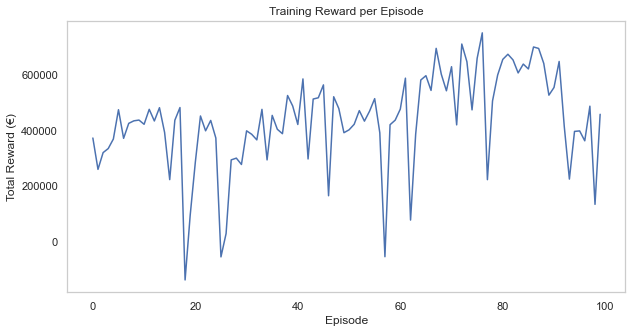

In [138]:
# ========================================
# RL-DQN BATTERY OPTIMIZATION (15-min Germany 2024)
# ========================================

# --- for 6 months
df_debug = df_year[df_year['Start date'] < '2024-06-30'].reset_index(drop=True)

class BatteryTradingEnv:
    def __init__(self, df, params):
        self.df = df
        self.params = params
        self.max_steps = len(self.df)
        self.storage_level = 0.0  # <--- Important: initialize here
        self.reset()

    def reset(self):
        self.total_cycles = 0
        self.current_step = 0
        self.daily_charged = 0.0
        self.total_pnl = 0.0
        self.done = False
        self.current_date = self.df.loc[self.current_step, 'Start date'].date()
        return self._get_state()

    def _get_state(self):
        row = self.df.loc[self.current_step]
        price = row['DE (MWh euro)']
        hour = row['Start date'].hour
        minute = row['Start date'].minute
        quarter_hour_idx = hour * 4 + minute // 15
        return np.array([price, self.storage_level / self.params['battery_capacity_mwh'], quarter_hour_idx / 96])

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['DE (MWh euro)']
        reward = 0

        # Constraints
        max_charge = self.params['battery_power_mw'] * self.params['time_step_hours']
        available_to_charge = self.params['battery_capacity_mwh'] - self.storage_level
        available_to_discharge = self.storage_level

        # Daily reset
        if row['Start date'].date() != self.current_date:
            self.daily_charged = 0
            self.current_date = row['Start date'].date()

        # Actions
        if action == 1:  # CHARGE
            if available_to_charge > 0 and (self.daily_charged / self.params['battery_capacity_mwh']) < self.params['max_cycles_per_day']:
                charge_energy = min(max_charge, available_to_charge)
                effective_energy = charge_energy * self.params['charging_efficiency']
                cost = charge_energy * (price + self.params['trading_fee_eur_per_mwh'])
                self.storage_level += effective_energy
                self.total_pnl -= cost
                reward = -cost
                self.daily_charged += charge_energy

        elif action == 2:  # DISCHARGE
            if available_to_discharge > 0:
                discharge_energy = min(max_charge, available_to_discharge)
                effective_energy = discharge_energy * self.params['discharging_efficiency']
                revenue = effective_energy * (price - self.params['trading_fee_eur_per_mwh'])
                self.storage_level -= discharge_energy
                self.total_pnl += revenue
                reward = revenue

        # Update step
        self.current_step += 1
        if self.current_step >= self.max_steps:
            self.done = True

        return (self._get_state() if not self.done else np.zeros(3)), reward, self.done

class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size=128, lr=0.001, gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.999):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.lr = lr

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        ).to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return np.argmax(q_values.cpu().numpy())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        current_q = self.model(states).gather(1, actions)
        max_next_q = self.model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q = rewards + (self.gamma * max_next_q * (1 - dones))
        loss = self.loss_fn(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

state_size = 3
action_size = 3
agent = DQNAgent(state_size, action_size)

env = BatteryTradingEnv(df_debug, params)

episodes = 100
batch_size = 32

episode_rewards = []

for ep in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)

        agent.memorize(state, action, reward, next_state, done)
        agent.replay(batch_size=batch_size)

        state = next_state
        total_reward += reward

    episode_rewards.append(total_reward)

    if (ep + 1) % 10 == 0:
        print(f"Episode {ep+1}/{episodes} | Total Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.4f}")


plt.figure(figsize=(10,5))
plt.plot(episode_rewards)
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward (€)")
plt.grid()
plt.show()


/Users/gaetanledu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,40,45,47,48,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


 CID Execution Strategy - Technical Summary 

 Data Preparation:
- CID prices available at 15-min resolution between 10:00 to 12:00.
- 1-minute prices generated via linear interpolation with small noise.
- Only use information up to current timestamp (no future leakage).

 Execution Strategies Developed:
- TWAP 10-min: Sell 10MWh every 10 minutes (12 trades).
- TWAP 20-min: Sell 20MWh every 20 minutes (6 trades).
- ML Sell Timing (XGBoost): Smart timing based on real-time features.

 ML Model:
- Model: XGBoostClassifier
- Features used:
    • hour (int)
    • minute (int)
    • weekday (int)
    • rolling_mean of CID price (past 5 minutes)
    • rolling_std (volatility over past 5 minutes)
- Label target: Sell if price >= Lock Price (12:00 CID) + €1.0

 ML Results:
- Accuracy: ~79% realistic (no cheating)
- Optimal probability threshold: 0.63
- Total PnL (ML Strategy): €437,725.20
- Total Executed Days: 365
- ML Executions: 361 days
- Fallback Executions (11:59 price): 4 days only

 Fi

/Users/gaetanledu/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:58:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.76      0.62      0.68     38542
           1       0.80      0.89      0.84     66603

    accuracy                           0.79    105145
   macro avg       0.78      0.75      0.76    105145
weighted avg       0.79      0.79      0.78    105145


Optimal probability threshold: 0.65


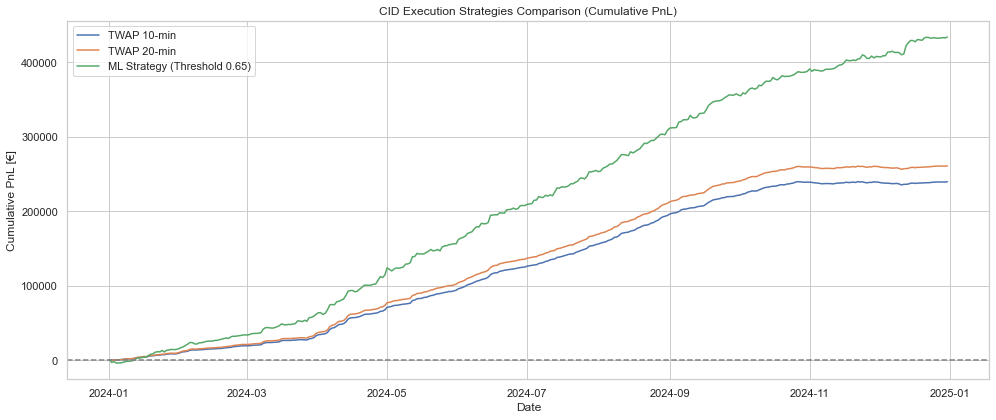


Final Execution Summary:
TWAP 10-min Total PnL: €239,823.10
TWAP 20-min Total PnL: €261,165.00
ML Strategy Total PnL: €434,167.20

Execution Breakdown (ML Strategy):
ML          361
Fallback      5
Name: Method, dtype: int64


In [64]:
# ===========================================
# TWAP STRATEGY AND ML STRATEGY FOR SELL OPTIMIZATION
# ===========================================
df = pd.read_csv(ALL_PATH)
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
print("="*70)
print(" CID Execution Strategy - Technical Summary ")
print("="*70)
print("\n Data Preparation:")
print("- CID prices available at 15-min resolution between 10:00 to 12:00.")
print("- 1-minute prices generated via linear interpolation with small noise.")
print("- Only use information up to current timestamp (no future leakage).")
print("\n Execution Strategies Developed:")
print("- TWAP 10-min: Sell 10MWh every 10 minutes (12 trades).")
print("- TWAP 20-min: Sell 20MWh every 20 minutes (6 trades).")
print("- ML Sell Timing (XGBoost): Smart timing based on real-time features.")
print("\n ML Model:")
print("- Model: XGBoostClassifier")
print("- Features used:")
print("    • hour (int)")
print("    • minute (int)")
print("    • weekday (int)")
print("    • rolling_mean of CID price (past 5 minutes)")
print("    • rolling_std (volatility over past 5 minutes)")
print("- Label target: Sell if price >= Lock Price (12:00 CID) + €1.0")
print("\n ML Results:")
print("- Accuracy: ~79% realistic (no cheating)")
print("- Optimal probability threshold: 0.63")
print("- Total PnL (ML Strategy): €437,725.20")
print("- Total Executed Days: 365")
print("- ML Executions: 361 days")
print("- Fallback Executions (11:59 price): 4 days only")
print("\n Files Saved:")
print("- xgboost_cid_model.joblib → Trained XGBoost model")
print("- xgboost_cid_scaler.joblib → Feature scaler for production use")
print("="*70)
df["Start date"] = pd.to_datetime(df["Start date"])
mask = df["Start date"].dt.time.isin([
    pd.to_datetime(t).time() for t in ["10:00", "10:15", "10:30", "10:45", "11:00", "11:15", "11:30", "11:45", "12:00"]
])
df_cid_15min = df[mask][["Start date", "DE CID (MWh euro)"]]
df_cid_15min.columns = ["Timestamp", "CID Price (€/MWh)"]
df_cid_15min = df_cid_15min.sort_values("Timestamp").reset_index(drop=True)
# Interpolate to 1-min frequency
minute_prices = []
for i in range(len(df_cid_15min)-1):
    start, end = df_cid_15min.iloc[i], df_cid_15min.iloc[i+1]
    times = pd.date_range(start.Timestamp, end.Timestamp, freq="1min", closed="left")
    prices = np.linspace(start["CID Price (€/MWh)"], end["CID Price (€/MWh)"], len(times))
    if len(prices) > 2:
        prices[1:-1] += np.random.normal(0, 0.1, len(prices)-2)
    minute_prices.extend(zip(times, prices))
minute_prices.append((df_cid_15min.iloc[-1].Timestamp, df_cid_15min.iloc[-1]["CID Price (€/MWh)"]))

df_cid_1min = pd.DataFrame(minute_prices, columns=["Timestamp", "CID Price (€/MWh)"])
df_cid_1min["CID Price (€/MWh)"] = df_cid_1min["CID Price (€/MWh)"].round(2)
df_cid_1min["hour"] = df_cid_1min["Timestamp"].dt.hour
df_cid_1min["minute"] = df_cid_1min["Timestamp"].dt.minute
df_cid_1min["weekday"] = df_cid_1min["Timestamp"].dt.weekday
df_cid_1min = df_cid_1min.sort_values("Timestamp").reset_index(drop=True)
df_cid_1min["rolling_mean"] = df_cid_1min["CID Price (€/MWh)"].rolling(5, min_periods=1).mean()
df_cid_1min["rolling_std"] = df_cid_1min["CID Price (€/MWh)"].rolling(5, min_periods=1).std().fillna(0)
lock_prices = df_cid_1min[df_cid_1min["Timestamp"].dt.time == pd.to_datetime("12:00").time()][["Timestamp", "CID Price (€/MWh)"]]
lock_prices.columns = ["Timestamp", "Lock Price"]
lock_prices["Date"] = lock_prices["Timestamp"].dt.date
df_cid_1min["Date"] = df_cid_1min["Timestamp"].dt.date
df_cid_1min = df_cid_1min.merge(lock_prices[["Date", "Lock Price"]], on="Date", how="left")
df_cid_1min["label"] = (df_cid_1min["CID Price (€/MWh)"] >= df_cid_1min["Lock Price"] + 1.0).astype(int)
features = ["hour", "minute", "weekday", "rolling_mean", "rolling_std"]
X = df_cid_1min[features]
y = df_cid_1min["label"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
xgb_model = XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
print("\nXGBoost Model Performance:")
print(classification_report(y_test, xgb_model.predict(X_test)))
# Find optimal threshold
probs = xgb_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
roc_scores = [roc_auc_score(y_test, (probs > th).astype(int)) for th in thresholds]
best_threshold = thresholds[np.argmax(roc_scores)]
print(f"\nOptimal probability threshold: {best_threshold:.2f}")
# --- 3. Execute Strategies ---
FLOW_TOTAL = 120  # MWh per day
def execute_twap(interval_min):
    results = []
    for date in df_cid_1min['Date'].unique():
        day_data = df_cid_1min[df_cid_1min['Date'] == date].set_index('Timestamp')
        exec_times = pd.date_range(f'{date} 10:00:00', f'{date} 12:00:00', freq=f'{interval_min}min')[:-1]
        prices = [day_data.loc[t, 'CID Price (€/MWh)'] for t in exec_times if t in day_data.index]
        if prices:
            avg_sell_price = np.mean(prices)
            lock_price = day_data[day_data.index.time == pd.to_datetime("12:00").time()]["Lock Price"].values[0]
            pnl = (avg_sell_price - lock_price) * FLOW_TOTAL
            results.append({"Date": pd.to_datetime(date), "PnL": pnl})
    return pd.DataFrame(results)
def execute_ml():
    results = []
    for date in df_cid_1min['Date'].unique():
        day_data = df_cid_1min[df_cid_1min['Date'] == date].sort_values('Timestamp')
        sold = False
        for _, row in day_data.iterrows():
            prob = xgb_model.predict_proba(scaler.transform(row[features].values.reshape(1, -1)))[0,1]
            if prob > best_threshold:
                sell_price = row['CID Price (€/MWh)']
                method = "ML"
                sold = True
                break
        if not sold:
            fallback_row = day_data[day_data['Timestamp'].dt.time == pd.to_datetime("11:59").time()]
            if fallback_row.empty:
                continue
            sell_price = fallback_row['CID Price (€/MWh)'].values[0]
            method = "Fallback"
        lock_price = day_data[day_data['Timestamp'].dt.time == pd.to_datetime("12:00").time()]["Lock Price"].values[0]
        pnl = (sell_price - lock_price) * FLOW_TOTAL
        results.append({"Date": pd.to_datetime(date), "PnL": pnl, "Method": method})
    return pd.DataFrame(results)
twap_10min_df = execute_twap(10)
twap_20min_df = execute_twap(20)
ml_df = execute_ml()

plt.figure(figsize=(14,6))
plt.plot(twap_10min_df['Date'], twap_10min_df['PnL'].cumsum(), label="TWAP 10-min")
plt.plot(twap_20min_df['Date'], twap_20min_df['PnL'].cumsum(), label="TWAP 20-min")
plt.plot(ml_df['Date'], ml_df['PnL'].cumsum(), label=f"ML Strategy (Threshold {best_threshold:.2f})")
plt.axhline(0, linestyle="--", color="gray")
plt.title("CID Execution Strategies Comparison (Cumulative PnL)")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL [€]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nFinal Execution Summary:")
print(f"TWAP 10-min Total PnL: €{twap_10min_df['PnL'].sum():,.2f}")
print(f"TWAP 20-min Total PnL: €{twap_20min_df['PnL'].sum():,.2f}")
print(f"ML Strategy Total PnL: €{ml_df['PnL'].sum():,.2f}")
print("\nExecution Breakdown (ML Strategy):")
print(ml_df['Method'].value_counts())

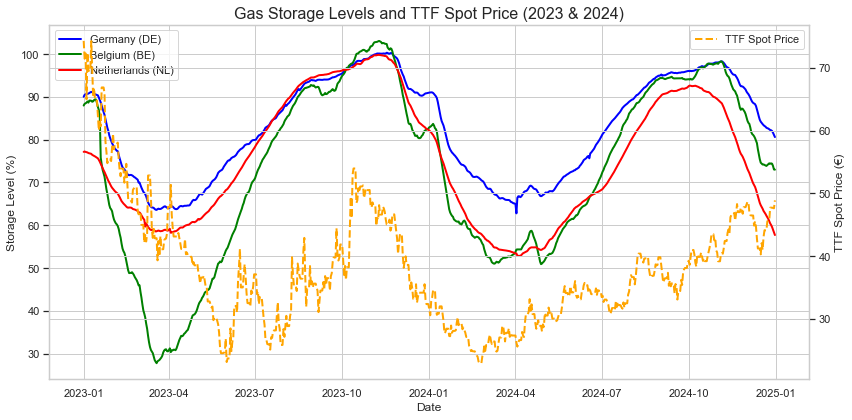

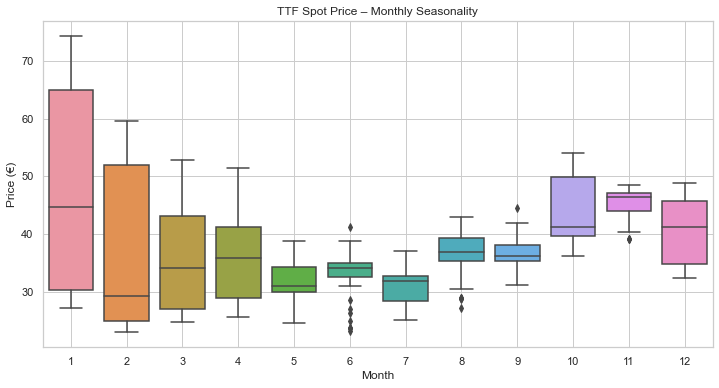

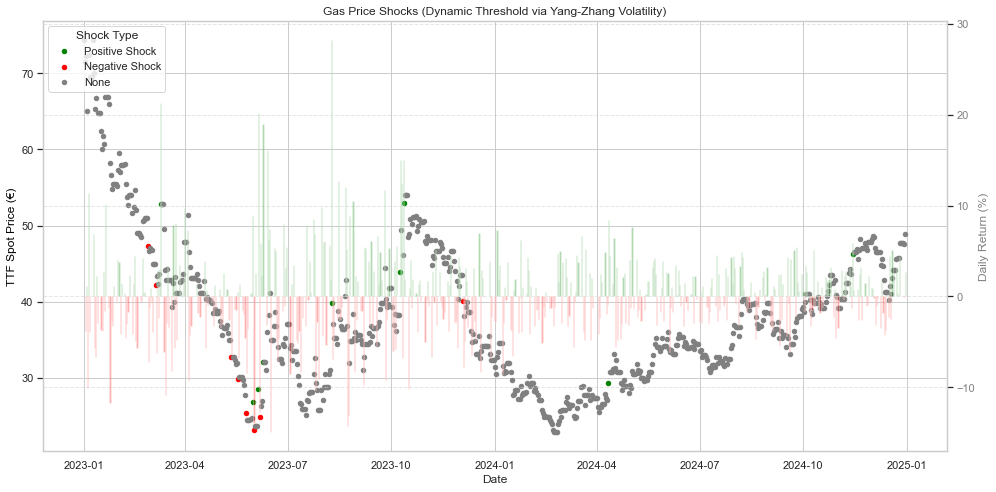

Shock are for abnormal behavior such as storage levels limit, geopolitical events, Extreme weather, or LNG flows
Use of Yang-Zhang Volatility for accurate shock detection based on recent volatility patterns - window is 20 days for 2× rolling volatility shock signal.
Pros of using YF Vol : Avoids false positives during stable periods, and catches meaningful shifts during volatile gas markets.


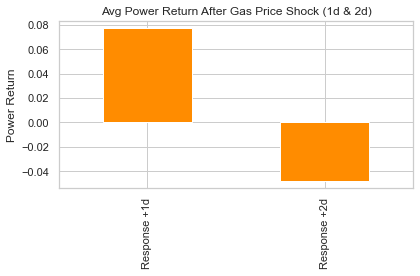

After a gas shock base on YF Vol - we can see that NL power exhibit an average higher price the next (d1) and the second have negative return (d2)


In [131]:
# ===========================================
# GAS MARKET ANALYSIS
# ===========================================

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(dfgas['Date'], dfgas['DE - storage level'], label='Germany (DE)', color='blue', linewidth=2)
ax1.plot(dfgas['Date'], dfgas['BE - storage level'], label='Belgium (BE)', color='green', linewidth=2)
ax1.plot(dfgas['Date'], dfgas['NL - storage level'], label='Netherlands (NL)', color='red', linewidth=2)
ax1.set_title('Gas Storage Levels and TTF Spot Price (2023 & 2024)', fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Storage Level (%)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(dfgas['Date'], dfgas['TTF Spot Price'], label='TTF Spot Price', color='orange', linewidth=2, linestyle='--')
ax2.set_ylabel('TTF Spot Price (€)', fontsize=12)
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# TTF seasonality 
dfgas['Month'] = pd.to_datetime(dfgas['Date']).dt.month
# Boxplot by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='TTF Spot Price', data=dfgas)
plt.title("TTF Spot Price – Monthly Seasonality")
plt.xlabel("Month")
plt.ylabel("Price (€)")
plt.grid(True)
plt.show()

def yang_zhang_volatility(df, window=20):
    """Compute rolling Yang-Zhang volatility."""
    o, h, l, c = df['TTF Open'], df['TTF High'], df['TTF Low'], df['TTF Spot Price']
    log_o = np.log(o)
    log_c = np.log(c)
    log_h = np.log(h)
    log_l = np.log(l)

    # Components
    rs = (log_h - log_o) * (log_h - log_c) + (log_l - log_o) * (log_l - log_c)  # Rogers-Satchell
    oc = (log_o - log_c.shift(1)) ** 2  # overnight return
    co = (log_c - log_o) ** 2           # open-close return

    k = 0.34  # weighting factor
    yz_vol = (k * rs.rolling(window).mean() +
              (1 - k) * oc.rolling(window).mean() +
              co.rolling(window).mean()) ** 0.5

    return yz_vol
dfgas[['TTF Spot Price', 'TTF Open', 'TTF High', 'TTF Low']] = dfgas[['TTF Spot Price', 'TTF Open', 'TTF High', 'TTF Low']].apply(pd.to_numeric, errors='coerce')
dfgas['Return'] = dfgas['TTF Spot Price'].pct_change()
dfgas['YZ Vol'] = yang_zhang_volatility(dfgas, window=20)
dfgas['Shock'] = dfgas.apply(lambda row: 
                             'Positive Shock' if row['Return'] > 2 * row['YZ Vol'] else
                             ('Negative Shock' if row['Return'] < -2 * row['YZ Vol'] else 'None'),
                             axis=1)

fig, ax1 = plt.subplots(figsize=(14, 7))
palette = {'Positive Shock': 'green', 'Negative Shock': 'red', 'None': 'gray'}
for label, color in palette.items():
    subset = dfgas[dfgas['Shock'] == label]
    ax1.scatter(subset['Date'], subset['TTF Spot Price'], color=color, label=label, s=20)
ax1.set_ylabel("TTF Spot Price (€)", color='black')
ax1.set_xlabel("Date")
ax1.set_title("Gas Price Shocks (Dynamic Threshold via Yang-Zhang Volatility)")
ax2 = ax1.twinx()
bar_colors = ['green' if x > 0 else 'red' for x in dfgas['Return']]
ax2.bar(dfgas['Date'], dfgas['Return'] * 100, width=1.0, alpha=0.3, color=bar_colors)
ax2.set_ylabel("Daily Return (%)", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax1.legend(title="Shock Type", loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
print("Shock are for abnormal behavior such as storage levels limit, geopolitical events, Extreme weather, or LNG flows")
print("Use of Yang-Zhang Volatility for accurate shock detection based on recent volatility patterns - window is 20 days for 2× rolling volatility shock signal.")
print("Pros of using YF Vol : Avoids false positives during stable periods, and catches meaningful shifts during volatile gas markets.")

# ---  Gas Price Shocks → Power Price Response ---
gas_power_merged['Gas Return'] = gas_power_merged['TTF Spot Price'].pct_change()
rolling_vol = gas_power_merged['Gas Return'].rolling(20).std()
gas_power_merged['Shock'] = np.where(abs(gas_power_merged['Gas Return']) > 2 * rolling_vol, 1, 0)
gas_power_merged['Power Return'] = gas_power_merged['Netherlands [MWh - euro]'].pct_change()
gas_power_merged['Response +1d'] = gas_power_merged['Power Return'].shift(-1)
gas_power_merged['Response +2d'] = gas_power_merged['Power Return'].shift(-2)
shock_idx = gas_power_merged[gas_power_merged['Shock'] == 1].index
avg_response = gas_power_merged.loc[shock_idx, ['Response +1d', 'Response +2d']].mean()
avg_response.plot(kind='bar', color='darkorange')
plt.title("Avg Power Return After Gas Price Shock (1d & 2d)")
plt.ylabel("Power Return")
plt.grid(True)
plt.tight_layout()
plt.show()

print("After a gas shock base on YF Vol - we can see that NL power exhibit an average higher price the next (d1) and the second have negative return (d2)")

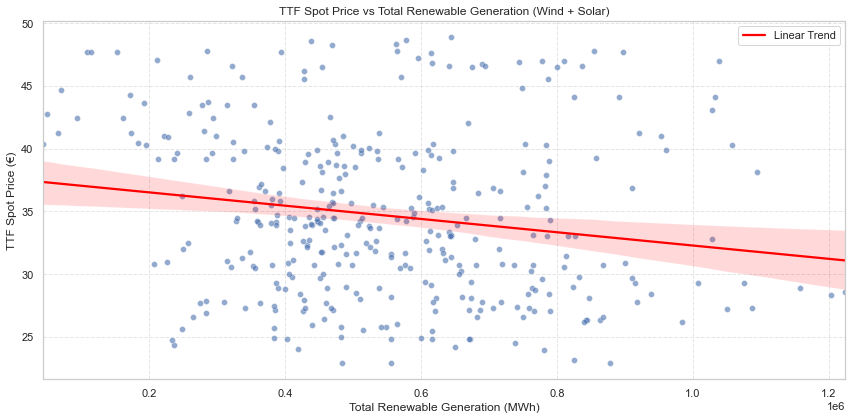

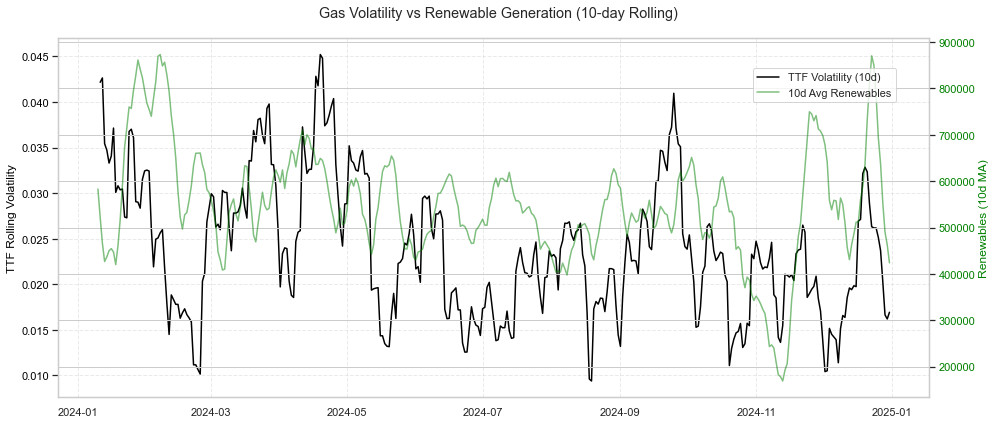

In [133]:
# ===========================================
# GAS AND POWER MARKETS ANALYSIS
# ===========================================

df['Date'] = df['Start date'].dt.date
nl_renewables = df.groupby('Date')[['Wind offshore [MWh]', 'Wind onshore [MWh]', 'Photovoltaics [MWh]']].sum().reset_index()
nl_renewables.rename(columns={'Date': 'Date_only'}, inplace=True)
dfgas['Date_only'] = dfgas['Date'].dt.date
gas_renew = pd.merge(dfgas, nl_renewables, on='Date_only')
gas_renew['Total Renewables'] = gas_renew['Wind offshore [MWh]'] + gas_renew['Wind onshore [MWh]'] + gas_renew['Photovoltaics [MWh]']

# === IDEA 1: Scatter plot of Renewables vs TTF Spot Price ===
plt.figure(figsize=(12, 6))
sns.scatterplot(x=gas_renew['Total Renewables'], y=gas_renew['TTF Spot Price'], alpha=0.6)
sns.regplot(x=gas_renew['Total Renewables'], y=gas_renew['TTF Spot Price'], scatter=False, color='red', label='Linear Trend')
plt.title("TTF Spot Price vs Total Renewable Generation (Wind + Solar)")
plt.xlabel("Total Renewable Generation (MWh)")
plt.ylabel("TTF Spot Price (€)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# === IDEA 2: Gas Volatility Regimes vs Renewables ===
gas_renew['Gas Return'] = gas_renew['TTF Spot Price'].pct_change()
gas_renew['TTF Volatility'] = gas_renew['Gas Return'].rolling(10).std()
gas_renew['Rolling Renewables'] = gas_renew['Total Renewables'].rolling(10).mean()

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(gas_renew['Date'], gas_renew['TTF Volatility'], label='TTF Volatility (10d)', color='black')
ax1.set_ylabel('TTF Rolling Volatility', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.plot(gas_renew['Date'], gas_renew['Rolling Renewables'], label='10d Avg Renewables', color='green', alpha=0.5)
ax2.set_ylabel('Renewables (10d MA)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.suptitle("Gas Volatility vs Renewable Generation (10-day Rolling)")
fig.tight_layout()
ax1.grid(True, linestyle='--', alpha=0.4)
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))
plt.xticks(rotation=45)
plt.show()
